# Import libraries & settings

In [1]:
import os

import pandas as pd

from bs4 import BeautifulSoup

import shutil

from tqdm import tqdm

import numpy as np

import matplotlib.pyplot as plt

import statsmodels.api as sm

import seaborn as sns

In [2]:
# Settings
pd.set_option('display.max_rows', 20)
pd.set_option('display.max_columns', 200)

In [3]:
# Path to root folder
dir_path = 'C:/Users/Adam/Documents/Out of the Park Developments/OOTP Baseball 24/saved_games/'

# Destination folder for processed game logs
destination_folder_pitchers = 'C:/Users/Adam/Desktop/OOTP/Pitchers_historical_logs'
destination_folder_batters = 'C:/Users/Adam/Desktop/OOTP/Batters_historical_logs'

# Destination folder for final data sets
destination_folder = 'C:/Users/Adam/Desktop/OOTP'

# Import and process logs

In [4]:
# Import HTML files
html_files = []

for root, dirs, files in os.walk(dir_path):
    if 'html' in dirs:
        temp_dir = os.path.join(root, 'html')
        if 'temp' in os.listdir(temp_dir):
            html_dir = os.path.join(temp_dir, 'temp')
            for file in os.listdir(html_dir):
                if file.endswith('.html'):
                    html_files.append(os.path.join(html_dir, file))


In [5]:
# Load the parquet "DBs" into a Pandas DataFrame
# https://towardsdatascience.com/the-best-format-to-save-pandas-data-414dca023e0d
# feather was impossible to set up
df_pitchers = pd.read_parquet(r'C:\Users\Adam\Desktop\OOTP\pitchers_db.parquet')
df_batters = pd.read_parquet(r'C:\Users\Adam\Desktop\OOTP\batters_db.parquet')

In [6]:
# ETL for new logs

for file in tqdm(html_files):
    # Reading the HTML file into a pandas DataFrame
    df = pd.read_html(file, flavor = 'bs4', skiprows=[0])[0]
    
    df = df.drop(0)
    df = df.rename(columns=df.iloc[0]).drop(df.index[0])
    
    duplicate_cols = df.columns[df.columns.duplicated()]

    # Get a boolean mask indicating which column names are duplicates
    dupe_mask = df.columns.duplicated()

    # Add a suffix to duplicate column names
    df.columns = df.columns.where(~dupe_mask, df.columns + '_other')

    # Add column with timestamp (file name)
    # To be used to filter out old logs
    base_name = os.path.basename(file)
    file_name, file_extension = os.path.splitext(base_name)
    df['file_name'] = file_name
    
    # Concatenate the DataFrames for pitchers and batters independently
    if df.columns[6] == "STU":
        df_pitchers = pd.concat([df_pitchers, df])
        # Move
        shutil.move(file, destination_folder_pitchers)
    else:
        # Drop first column for batters
        df = df.drop(df.columns[0], axis=1)
        df_batters = pd.concat([df_batters, df])
        shutil.move(file, destination_folder_batters)

100%|███████████████████████████████████████████████████████████████████████████████████| 4/4 [06:40<00:00, 100.13s/it]


In [7]:
# name unification
df_pitchers.loc[(df_pitchers['ORG'] == 'Fogtown Stars TBD'),'ORG'] ='Fogtown Stars'
df_batters.loc[(df_batters['ORG'] == 'Fogtown Stars TBD'),'ORG'] ='Fogtown Stars'

# Overwrite of wrong positions
df_batters.loc[(df_batters['ORG'] == 'Fogtown Stars') & (df_batters['Name'] == 'Evan Gattis'),'POS'] ='C'	

In [8]:
# Store unaggregated data between sessions in parquet file
df_pitchers.to_parquet(r'C:\Users\Adam\Desktop\OOTP\pitchers_db.parquet')
df_batters.to_parquet(r'C:\Users\Adam\Desktop\OOTP\batters_db.parquet')

# Prepare Dataframes

In [9]:
# Filter out old games
df_pitchers = df_pitchers[df_pitchers['file_name'] > '2024-01-07']
df_batters = df_batters[df_batters['file_name'] > '2024-01-07']

In [10]:
# df_batters[(df_batters['ORG'] == 'Fogtown Stars') &(df_batters['POS'] == 'C') & (df_batters['Name'] == 'Evan Gattis')][['wRC','RC','wOBA','TB','H','AB','BB']]

## Data Types

### Pitchers

In [11]:
pitchers_data_types = {
                "POS": str, "Name": str, "ORG": str, "B": str, "T": str, "OVR": int, "STU": int,
                "MOV": int, "CON": int, "PBABIP": int, "HRR": int, "STU vL": int, "MOV vL": int,
                "CON vL": int, "PBABIP vL": int, "HRR vL": int, "STU vR": int, "MOV vR": int,
                "CON vR": int, "PBABIP vR": int, "HRR vR": int, "FB": int, "CH": int, "CB": int,
                "SL": int, "SI": int, "SP": int, "CT": int, "FO": int, "CC": int, "SC": int,
                "KC": int, "KN": int, "PIT": int, "G/F": str, "VELO": str, "Slot": str, "PT": str,
                "STM": int, "HLD": int, "IF RNG": int, "IF ERR": int, "IF ARM": int, "P": int,
                "G": int, "GS": int, "W": int, "L": int, "WIN%": float, "SVO": int, "SV": int,
                "SV%": float, "BS": int, "BS%": float, "HLD_other": int, "SD": int, "MD": int,
                "IP": float, "BF": int, "AB": int, "HA": int, "1B": int, "2B": int, "3B": int,
                "HR": int, "TB": int, "R": int, "ER": int, "BB": int, "IBB": int, "K": int,
                "HP": int, "ERA": float, "AVG": float, "OBP": float, "SLG": float, "OPS": float,
                "BABIP": float, "WHIP": float, "RA/9": float, "HR/9": float, "H/9": float,
                "BB/9": float, "K/9": float, "K/BB": float, "K%": float, "BB%": float,
                "K%-BB%": float, "SH": int, "SF": int, "WP": int, "BK": int, "CI": int, "DP": int,
                "RA": int, "GF": int, "IR": int, "IRS": int, "IRS%": float, "LOB%": float,
                "pLi": float, "GF%": float, "QS": int, "QS%": float, "CG": int, "CG%": float,
                "SHO": int, "PPG": int, "RS": int, "RSG": float, "PI": int, "GB": int,
                "FB_other": int, "GO%": float, "SB": int, "CS": int, "ERA+": int, "FIP": float,
                "FIP-": float, "WPA": float, "WAR": float, "rWAR": float, "SIERA": float,
                "TC": int, "A": int, "PO": int, "E": int, "DP_other": int, "TP": int, "PCT": float,
                "RNG": float, "ZR": float, "EFF": float}

In [12]:
for col, dtype in pitchers_data_types.items():
    if df_pitchers[col].dtype != dtype and dtype != 'str':
        df_pitchers[col] = df_pitchers[col].replace('-', 0)
        #df_pitchers[col] = pd.to_numeric(df_pitchers[col], errors='coerce').astype(dtype)
        df_pitchers[col] = df_pitchers[col].astype(dtype, errors = 'ignore')
        

In [13]:
df_pitchers = df_pitchers.convert_dtypes().reset_index(drop=True)
df_pitchers['VELO'] = df_pitchers['VELO'].str.split('-').str[0]

In [14]:
# decimal format of innings pitched 
df_pitchers['IP'] = df_pitchers['IP'].apply(lambda x: int(x) + (x % 1 * 10) / 3)

### Batters

In [15]:
batters_data_types = {'POS': str, 'Name': str, 'ORG': str, 'Lev': str, 'HT': str, 'B': str, 'T': str, 'OVR': int, 
                'BABIP': int, 'CON': int, 'GAP': int, 'POW': int, 'EYE': int, 'K\'s': int, 'BABIP vL': int, 
                'CON vL': int, 'GAP vL': int, 'POW vL': int, 'EYE vL': int, 'K vL': int, 'BABIP vR': int, 
                'CON vR': int, 'GAP vR': int, 'POW vR': int, 'EYE vR': int, 'K vR': int, 'BUN': int, 'BFH': int, 
                'BBT': str, 'GBT': str, 'FBT': str, 'C ABI': int, 'C ARM': int, 'IF RNG': int, 'IF ERR': int, 
                'IF ARM': int, 'TDP': int, 'OF RNG': int, 'OF ERR': int, 'OF ARM': int, 'DEF': int, 'P': int, 
                'C': int, '1B': int, '2B': int, '3B': int, 'SS': int, 'LF': int, 'CF': int, 'RF': int, 'SPE': int, 
                'STE': int, 'RUN': int, 'G': int, 'GS': int, 'PA': int, 'AB': int, 'H': int, '1B_other': int, 
                '2B_other': int, '3B_other': int, 'HR': int, 'RBI': int, 'R': int, 'BB': int, 'BB%': float, 'IBB': int, 
                'HP': int, 'SH': int, 'SF': int, 'CI': int, 'SO': int, 'SO%': float, 'GIDP': int, 'EBH': int, 'TB': int, 
                'AVG': float, 'OBP': float, 'SLG': float, 'RC': float, 'RC/27': float, 'ISO': float, 'wOBA': float, 'OPS': float,  
                'OPS+': int, 'BABIP_other': float, 'WPA': float, 'wRC': int, 'wRC+': int, 'wRAA': float, 'WAR': float, 
                'PI/PA': float, 'SB': int, 'CS': int, 'SB%': float, 'BatR': float, 'wSB': float, 'UBR': float, 'BsR': float, 
                'G_other': int, 'GS_other': int, 'TC': int, 'A': int, 'PO': int, 'E': int, 'DP': int, 'TP': int, 
                'PCT': float, 'RNG': float, 'ZR': float, 'EFF': float, 'SBA': int, 'RTO': int, 'RTO%': float, 'IP': float, 
                'PB': int, 'CER': int, 'CERA': float, 'BIZ-R%': float, 'BIZ-R': int, 'BIZ-Rm': int, 'BIZ-L%': float, 
                'BIZ-L': int, 'BIZ-Lm': int, 'BIZ-E%': float, 'BIZ-E': int, 'BIZ-Em': int, 'BIZ-U%': float, 
                'BIZ-U': int, 'BIZ-Um': int, 'BIZ-Z%': float, 'BIZ-Z': int, 'BIZ-Zm': int, 'BIZ-I': int, 'FRM': float, 
                'ARM': float, 'BF%': float}


In [16]:
df_batters['GS'].fillna('0', inplace=True)
df_batters['G'].replace({None: '0'}, inplace=True)

In [17]:
for col, dtype in batters_data_types.items():
    if df_batters[col].dtype != dtype and dtype != 'str':
        df_batters[col] = df_batters[col].replace('-', 0)
        #df_batters[col] = pd.to_numeric(df_batters[col], errors='coerce').astype(dtype)
        if col in ['BIZ-R%', 'BIZ-L%', 'BIZ-E%', 'BIZ-U%', 'BIZ-Z%', 'BF%']:
            df_batters[col] = df_batters[col].str.replace('%', '')
        df_batters[col] = df_batters[col].astype(dtype, errors = 'ignore')

In [18]:
df_batters = df_batters.convert_dtypes().reset_index(drop=True)

### wRC calculation

In [19]:
#### wRC = (((wOBA-League wOBA)/wOBA Scale)+(League R/PA))*PA
# wRC / PA = ((wOBA-League wOBA)/wOBA Scale)+(League R/PA)
# (wRC / PA) - (League R/PA) = (wOBA-League wOBA)/wOBA Scale
# wOBA Scale = (wOBA-League wOBA)/((wRC / PA) - (League R/PA))

In [20]:
scaler_temp = df_batters[df_batters['wRC'] > 5][['wOBA','wRC','PA']]
scaler_temp['scaler'] = (scaler_temp['wOBA'] - 0.342) / (scaler_temp['wRC']/scaler_temp['PA'] - 0.1268)
scaler_temp = scaler_temp['scaler'].mean()
scaler_temp

1.0822313336245308

In [21]:
woba_league = (df_batters[np.isnan(df_batters['wOBA']) == False]['wOBA']*df_batters[np.isnan(df_batters['wOBA']) == False]['PA']).sum()/df_batters[np.isnan(df_batters['wOBA']) == False]['PA'].sum()
woba_league

0.34651014299749655

In [22]:
league_rppa = df_batters[np.isnan(df_batters['R']) == False]['R'].sum()/df_batters[np.isnan(df_batters['PA']) == False]['PA'].sum()
league_rppa

0.12915525613448706

In [23]:
wrc_temp = df_batters[np.isnan(df_batters['wRC']) == False][['wRC','PA']]
wrc_temp['wRC_calc'] = wrc_temp['wRC'] #/ wrc_temp['PA']
wrc_temp = wrc_temp[wrc_temp['wRC_calc'].notna()]
wrc_temp = wrc_temp[np.isnan(wrc_temp['wRC_calc']) == False]
wrc_temp = wrc_temp['wRC_calc'].sum() / wrc_temp['PA'].sum() * 600
wrc_temp

70.33348674311044

In [24]:
#df_batters['wRC_calc'] = (((df_batters['wOBA']-woba_league/scaler_temp)+(league_rppa)))*df_batters['PA']

## Aggregations

### Pitcher aggregations

Following method was too slow:

wm = lambda x: np.average(x, weights=df_pitchers.loc[x.index, 'IP']) if df_pitchers.loc[x.index, 'IP'].sum() > 0 else np.nan

ip9 = lambda x: np.average(x * (9/df_pitchers.loc[x.index, 'IP']), weights=df_pitchers.loc[x.index, 'IP']) if 

df_pitchers.loc[x.index, 'IP'].sum() > 0 else np.nan

lambda_fncs = {col: ['sum', 'mean', wm, ip9] for col in df_pitchers.columns[53:]}

%%time

pitch_agg = df_pitchers_copy.agg(lambda_fncs)

In [25]:
wm_col = ["WIN%", "SV%", "BS%", "AVG", "OBP", "SLG", "OPS", "BABIP", "WHIP", "K/BB", "K%", "BB%", "K%-BB%", "IRS%", "LOB%", "pLi", "GF%", "QS%", "CG%", "PPG", "RS", "RSG", "PI", "GB", "FB_other", "GO%", "SB", "CS", "FIP", "FIP-", "SIERA", "PCT", "RNG", "ZR", "EFF"]

ip9_list = []

for item in df_pitchers[df_pitchers.iloc[:, 44:].columns]:
    if item not in wm_col:
            if (item != 'IP') & (item != 'file_name'):
                ip9_list.append(item)

In [26]:
# Aggregation per player and team
df_pitchers_agg_team = df_pitchers.drop(columns=['file_name']).copy()

df_pitchers_agg_team[wm_col] = df_pitchers_agg_team[wm_col].mul(df_pitchers_agg_team['IP'], axis=0)

# Group by the ratings' columns and sum the values
df_pitchers_agg_team = df_pitchers_agg_team.groupby(df_pitchers_agg_team.iloc[:, :44].columns.tolist()).sum()
df_pitchers_agg_team = df_pitchers_agg_team.reset_index()

# Save IP stats
df_pitchers_agg_team_IP = df_pitchers_agg_team['IP']

# Calculate statistics per 9 innings and update the corresponding columns
df_pitchers_agg_team[df_pitchers_agg_team.iloc[:, 44:].columns] = df_pitchers_agg_team[df_pitchers_agg_team.columns[44:]].div(df_pitchers_agg_team['IP'], axis=0)
df_pitchers_agg_team[ip9_list] = df_pitchers_agg_team[ip9_list].mul(9, axis=0)


# Drop columns that were already per 9 innings
df_pitchers_agg_team = df_pitchers_agg_team.drop(columns=['RA/9','HR/9','H/9','BB/9','K/9','ERA+'])

# Restore IP stats
df_pitchers_agg_team['AVG_IP'] = df_pitchers_agg_team['IP']
df_pitchers_agg_team['IP'] = df_pitchers_agg_team_IP

In [27]:
# Round only the float columns to 3 decimal places
float_cols = df_pitchers_agg_team.select_dtypes(include=['float64']).columns
df_pitchers_agg_team[float_cols] = df_pitchers_agg_team[float_cols].round(3)

In [28]:
# Aggregation per player
df_pitchers_agg = df_pitchers.copy()

df_pitchers_agg = df_pitchers_agg.drop(columns='ORG')

df_pitchers_agg[wm_col] = df_pitchers_agg[wm_col].mul(df_pitchers_agg['IP'], axis=0)

# Group by the ratings' columns and sum the values
df_pitchers_agg = df_pitchers_agg.groupby(df_pitchers_agg.iloc[:, :43].columns.tolist()).sum()

df_pitchers_agg = df_pitchers_agg.reset_index()

# Save IP stats
df_pitchers_agg_IP = df_pitchers_agg['IP']

# Calculate statistics per 9 innings and update the corresponding columns
df_pitchers_agg[df_pitchers_agg.iloc[:, 43:].columns] = df_pitchers_agg[df_pitchers_agg.columns[43:]].div(df_pitchers_agg['IP'], axis=0)
df_pitchers_agg[ip9_list] = df_pitchers_agg[ip9_list].mul(9, axis=0)


# Drop columns that were already per 9 innings
df_pitchers_agg = df_pitchers_agg.drop(columns=['RA/9','HR/9','H/9','BB/9','K/9','ERA+'])

# Restore IP stats
df_pitchers_agg['AVG_IP'] = df_pitchers_agg['IP']
df_pitchers_agg['IP'] = df_pitchers_agg_IP

C:\Users\Adam\AppData\Local\Temp\ipykernel_14680\4162210481.py:9: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_pitchers_agg = df_pitchers_agg.groupby(df_pitchers_agg.iloc[:, :43].columns.tolist()).sum()


In [29]:
# Round only the float columns to 3 decimal places
float_cols = df_pitchers_agg.select_dtypes(include=['float64']).columns
df_pitchers_agg[float_cols] = df_pitchers_agg[float_cols].round(3)

### Batter aggregations

In [30]:
pa600_list = ['G', 'GS','AB', 'H', '1B_other', '2B_other', '3B_other', 'HR', 'RBI', 'R', 'BB', 'IBB', 'HP', 'SH', 'SF', 'CI', 'SO', 'GIDP', 'EBH', 'TB', 'WPA', 'wRC', 'wRAA', 'WAR', 'SB', 'CS', 'BatR', 'wSB', 'UBR', 'BsR', 'G_other', 'GS_other', 'TC', 'A', 'PO', 'E', 'DP', 'TP', 'SBA', 'RTO', 'FRM', 'ARM']
wm_def_col = ['ZR', 'PCT','PB', 'CER', 'BIZ-R', 'BIZ-Rm', 'BIZ-L', 'BIZ-Lm', 'BIZ-E', 'BIZ-Em', 'BIZ-U', 'BIZ-Um', 'BIZ-Z', 'BIZ-Zm', 'BIZ-I']

wm_col = []

for item in df_batters[df_batters.iloc[:, 53:].columns]:
    if item not in pa600_list:
        if item not in wm_def_col:
            if (item != 'file_name'):
                wm_col.append(item)


In [31]:
# Aggregation per player and team
df_batters_agg_team = df_batters.drop(columns=['file_name']).copy()

df_batters_agg_team['PA_WM'] = df_batters_agg_team['PA']
df_batters_agg_team['IP_WM'] = df_batters_agg_team['IP']
df_batters_agg_team[wm_col] = df_batters_agg_team[wm_col].mul(df_batters_agg_team['PA_WM'], axis=0)
#df_batters_agg_team[pa600_list] = df_batters_agg_team[pa600_list].mul(df_batters_agg_team['PA_WM'], axis=0)
#df_batters_agg_team[wm_def_col] = df_batters_agg_team[wm_def_col].mul(df_batters_agg_team['IP_WM'], axis=0)

# Group by the ratings' columns and sum the values
df_batters_agg_team = df_batters_agg_team.groupby(df_batters_agg_team.iloc[:, :53].columns.tolist()).sum()

# Reset index
df_batters_agg_team = df_batters_agg_team.reset_index()

# Calculate statistics per 600 PAs (and 9 inning) and update the corresponding columns
df_batters_agg_team[wm_col] = df_batters_agg_team[wm_col].div(df_batters_agg_team['PA_WM'], axis=0)
df_batters_agg_team[pa600_list] = df_batters_agg_team[pa600_list].div(df_batters_agg_team['PA_WM'], axis=0)
df_batters_agg_team[wm_def_col] = df_batters_agg_team[wm_def_col].div(df_batters_agg_team['IP_WM'], axis=0)
df_batters_agg_team[pa600_list] = df_batters_agg_team[pa600_list].mul(600, axis=0)
df_batters_agg_team[wm_def_col] = df_batters_agg_team[wm_def_col].mul(1200, axis=0)

In [32]:
df_batters_agg_team['wRC_calc'] = (((df_batters_agg_team['wOBA']-woba_league/scaler_temp)+(league_rppa)))*600

# Round only the float columns to 3 decimal places
float_cols = df_batters_agg_team.select_dtypes(include=['float64']).columns
df_batters_agg_team[float_cols] = df_batters_agg_team[float_cols].round(3)

In [33]:
# Aggregation per player
df_batters_agg = df_batters.copy()

df_batters_agg = df_batters_agg.drop(columns='ORG')

df_batters_agg['PA_WM'] = df_batters_agg['PA']
df_batters_agg['IP_WM'] = df_batters_agg['IP']
df_batters_agg[wm_col] = df_batters_agg[wm_col].mul(df_batters_agg['PA_WM'], axis=0)
#df_batters_agg[pa600_list] = df_batters_agg[pa600_list].mul(df_batters_agg['PA_WM'], axis=0)
#df_batters_agg[wm_def_col] = df_batters_agg[wm_def_col].mul(df_batters_agg['IP_WM'], axis=0)

# Group by the ratings' columns and sum the values
df_batters_agg = df_batters_agg.groupby(df_batters_agg.iloc[:, :52].columns.tolist()).sum()
df_batters_agg = df_batters_agg.reset_index()

# Calculate statistics per 600 PAs and update the corresponding columns
df_batters_agg[wm_col] = df_batters_agg[wm_col].div(df_batters_agg['PA_WM'], axis=0)
df_batters_agg[pa600_list] = df_batters_agg[pa600_list].div(df_batters_agg['PA_WM'], axis=0)
df_batters_agg[wm_def_col] = df_batters_agg[wm_def_col].div(df_batters_agg['IP_WM'], axis=0)
df_batters_agg[pa600_list] = df_batters_agg[pa600_list].mul(600, axis=0)
df_batters_agg[wm_def_col] = df_batters_agg[wm_def_col].mul(1200, axis=0)

C:\Users\Adam\AppData\Local\Temp\ipykernel_14680\3477946482.py:13: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_batters_agg = df_batters_agg.groupby(df_batters_agg.iloc[:, :52].columns.tolist()).sum()


In [34]:
df_batters_agg['wRC_calc'] = (((df_batters_agg['wOBA']-woba_league/scaler_temp)+(league_rppa)))*600

# Round only the float columns to 3 decimal places
float_cols = df_batters_agg.select_dtypes(include=['float64']).columns
df_batters_agg[float_cols] = df_batters_agg[float_cols].round(3)

### Team aggregations

In [35]:
# preparation of position columns for weighted average
df_batters['AVG_C'] = (np.where(df_batters['POS'] == 'C', df_batters['C'], 0) * np.where((df_batters['POS'] == 'C') & (df_batters['C'] > 0), df_batters['IP'], 0)).astype(int)
df_batters['IP_C'] = np.where((df_batters['POS'] == 'C') & (df_batters['C'] > 0), df_batters['IP'], 0).astype(int)
df_batters['FRM_C'] = (np.where(df_batters['POS'] == 'C', df_batters['FRM'], 0) * np.where((df_batters['POS'] == 'C') & (df_batters['C'] > 0), df_batters['IP'], 0)).astype(int)
df_batters['AVG_1B'] = (np.where(df_batters['POS'] == '1B', df_batters['1B'], 0) * np.where((df_batters['POS'] == '1B') & (df_batters['1B'] > 0), df_batters['IP'], 0)).astype(int)
df_batters['IP_1B'] = np.where((df_batters['POS'] == '1B') & (df_batters['1B'] > 0), df_batters['IP'], 0).astype(int)
df_batters['ZR_1B'] = (np.where(df_batters['POS'] == '1B', df_batters['ZR'], 0) * np.where((df_batters['POS'] == '1B') & (df_batters['1B'] > 0), df_batters['IP'], 0)).astype(int)
df_batters['PCT_1B'] = (np.where(df_batters['POS'] == '1B', df_batters['PCT'], 0) * np.where((df_batters['POS'] == '1B') & (df_batters['1B'] > 0), df_batters['IP'], 0)).astype(int)
df_batters['AVG_2B'] = (np.where(df_batters['POS'] == '2B', df_batters['2B'], 0) * np.where((df_batters['POS'] == '2B') & (df_batters['2B'] > 0), df_batters['IP'], 0)).astype(int)
df_batters['IP_2B'] = np.where((df_batters['POS'] == '2B') & (df_batters['2B'] > 0), df_batters['IP'], 0).astype(int)
df_batters['ZR_2B'] = (np.where(df_batters['POS'] == '2B', df_batters['ZR'], 0) * np.where((df_batters['POS'] == '2B') & (df_batters['2B'] > 0), df_batters['IP'], 0)).astype(int)
df_batters['PCT_2B'] = (np.where(df_batters['POS'] == '2B', df_batters['PCT'], 0) * np.where((df_batters['POS'] == '2B') & (df_batters['2B'] > 0), df_batters['IP'], 0)).astype(int)
df_batters['AVG_3B'] = (np.where(df_batters['POS'] == '3B', df_batters['3B'], 0) * np.where((df_batters['POS'] == '3B') & (df_batters['3B'] > 0), df_batters['IP'], 0)).astype(int)
df_batters['IP_3B'] = np.where((df_batters['POS'] == '3B') & (df_batters['3B'] > 0), df_batters['IP'], 0).astype(int)
df_batters['ZR_3B'] = (np.where(df_batters['POS'] == '3B', df_batters['ZR'], 0) * np.where((df_batters['POS'] == '3B') & (df_batters['3B'] > 0), df_batters['IP'], 0)).astype(int)
df_batters['PCT_3B'] = (np.where(df_batters['POS'] == '3B', df_batters['PCT'], 0) * np.where((df_batters['POS'] == '3B') & (df_batters['3B'] > 0), df_batters['IP'], 0)).astype(int)
df_batters['AVG_SS'] = (np.where(df_batters['POS'] == 'SS', df_batters['SS'], 0) * np.where((df_batters['POS'] == 'SS') & (df_batters['SS'] > 0), df_batters['IP'], 0)).astype(int)
df_batters['IP_SS'] = np.where((df_batters['POS'] == 'SS') & (df_batters['SS'] > 0), df_batters['IP'], 0).astype(int)
df_batters['ZR_SS'] = (np.where(df_batters['POS'] == 'SS', df_batters['ZR'], 0) * np.where((df_batters['POS'] == 'SS') & (df_batters['SS'] > 0), df_batters['IP'], 0)).astype(int)
df_batters['PCT_SS'] = (np.where(df_batters['POS'] == 'SS', df_batters['PCT'], 0) * np.where((df_batters['POS'] == 'SS') & (df_batters['SS'] > 0), df_batters['IP'], 0)).astype(int)
df_batters['AVG_LF'] = (np.where(df_batters['POS'] == 'LF', df_batters['LF'], 0) * np.where((df_batters['POS'] == 'LF') & (df_batters['LF'] > 0), df_batters['IP'], 0)).astype(int)
df_batters['IP_LF'] = np.where((df_batters['POS'] == 'LF') & (df_batters['LF'] > 0), df_batters['IP'], 0).astype(int)
df_batters['ZR_LF'] = (np.where(df_batters['POS'] == 'LF', df_batters['ZR'], 0) * np.where((df_batters['POS'] == 'LF') & (df_batters['LF'] > 0), df_batters['IP'], 0)).astype(int)
df_batters['PCT_LF'] = (np.where(df_batters['POS'] == 'LF', df_batters['PCT'], 0) * np.where((df_batters['POS'] == 'LF') & (df_batters['LF'] > 0), df_batters['IP'], 0)).astype(int)
df_batters['AVG_CF'] = (np.where(df_batters['POS'] == 'CF', df_batters['CF'], 0) * np.where((df_batters['POS'] == 'CF') & (df_batters['CF'] > 0), df_batters['IP'], 0)).astype(int)
df_batters['IP_CF'] = np.where((df_batters['POS'] == 'CF') & (df_batters['CF'] > 0), df_batters['IP'], 0).astype(int)
df_batters['ZR_CF'] = (np.where(df_batters['POS'] == 'CF', df_batters['ZR'], 0) * np.where((df_batters['POS'] == 'CF') & (df_batters['CF'] > 0), df_batters['IP'], 0)).astype(int)
df_batters['PCT_CF'] = (np.where(df_batters['POS'] == 'CF', df_batters['PCT'], 0) * np.where((df_batters['POS'] == 'CF') & (df_batters['CF'] > 0), df_batters['IP'], 0)).astype(int)
df_batters['AVG_RF'] = (np.where(df_batters['POS'] == 'RF', df_batters['RF'], 0) * np.where((df_batters['POS'] == 'RF') & (df_batters['RF'] > 0), df_batters['IP'], 0)).astype(int)
df_batters['IP_RF'] = np.where((df_batters['POS'] == 'RF') & (df_batters['RF'] > 0), df_batters['IP'], 0).astype(int)
df_batters['ZR_RF'] = (np.where(df_batters['POS'] == 'RF', df_batters['ZR'], 0) * np.where((df_batters['POS'] == 'RF') & (df_batters['RF'] > 0), df_batters['IP'], 0)).astype(int)
df_batters['PCT_RF'] = (np.where(df_batters['POS'] == 'RF', df_batters['PCT'], 0) * np.where((df_batters['POS'] == 'RF') & (df_batters['RF'] > 0), df_batters['IP'], 0)).astype(int)
df_batters['AVG_BABIP'] = df_batters['BABIP'] * df_batters['PA']
df_batters['AVG_GAP'] = df_batters['GAP'] * df_batters['PA']
df_batters['AVG_POW'] = df_batters['POW'] * df_batters['PA']
df_batters['AVG_EYE'] = df_batters['EYE'] * df_batters['PA']
df_batters['AVG_KS'] = df_batters["K's"] * df_batters['PA']

In [36]:
# aggregation
df_team_agg_temp = df_batters.groupby('ORG')[['1B_other','2B_other','HR', 'R', 'BB','SB','AVG_C', 'IP_C', 'FRM_C','AVG_1B', 'IP_1B', 'ZR_1B', 'PCT_1B','AVG_2B', 'IP_2B','ZR_2B','PCT_2B','AVG_3B', 'IP_3B','ZR_3B','PCT_3B','AVG_SS', 'IP_SS','ZR_SS','PCT_SS','AVG_LF', 'IP_LF','ZR_LF','PCT_LF','AVG_CF', 'IP_CF','ZR_CF','PCT_CF','AVG_RF', 'IP_RF','ZR_RF','PCT_RF','IP', 'PA','AVG_BABIP','AVG_GAP','AVG_POW','AVG_EYE','AVG_KS']].sum().reset_index()
df_team_agg_temp = df_team_agg_temp.rename(columns={'1B_other':'SINGLE','2B_other':'DOUBLE'})

In [37]:
# w. averages
df_team_agg_temp['AVG_C'] = df_team_agg_temp['AVG_C']/df_team_agg_temp['IP_C']
df_team_agg_temp['AVG_1B'] = df_team_agg_temp['AVG_1B']/df_team_agg_temp['IP_1B']
df_team_agg_temp['AVG_2B'] = df_team_agg_temp['AVG_2B']/df_team_agg_temp['IP_2B']
df_team_agg_temp['AVG_3B'] = df_team_agg_temp['AVG_3B']/df_team_agg_temp['IP_3B']
df_team_agg_temp['AVG_SS'] = df_team_agg_temp['AVG_SS']/df_team_agg_temp['IP_SS']
df_team_agg_temp['AVG_LF'] = df_team_agg_temp['AVG_LF']/df_team_agg_temp['IP_LF']
df_team_agg_temp['AVG_CF'] = df_team_agg_temp['AVG_CF']/df_team_agg_temp['IP_CF']
df_team_agg_temp['AVG_RF'] = df_team_agg_temp['AVG_RF']/df_team_agg_temp['IP_RF']

df_team_agg_temp['FRM_C'] = df_team_agg_temp['FRM_C']/df_team_agg_temp['IP_C']
df_team_agg_temp['ZR_1B'] = df_team_agg_temp['ZR_1B']/df_team_agg_temp['IP_1B']
df_team_agg_temp['ZR_2B'] = df_team_agg_temp['ZR_2B']/df_team_agg_temp['IP_2B']
df_team_agg_temp['ZR_3B'] = df_team_agg_temp['ZR_3B']/df_team_agg_temp['IP_3B']
df_team_agg_temp['ZR_SS'] = df_team_agg_temp['ZR_SS']/df_team_agg_temp['IP_SS']
df_team_agg_temp['ZR_LF'] = df_team_agg_temp['ZR_LF']/df_team_agg_temp['IP_LF']
df_team_agg_temp['ZR_CF'] = df_team_agg_temp['ZR_CF']/df_team_agg_temp['IP_CF']
df_team_agg_temp['ZR_RF'] = df_team_agg_temp['ZR_RF']/df_team_agg_temp['IP_RF']

df_team_agg_temp['PCT_1B'] = df_team_agg_temp['PCT_1B']/df_team_agg_temp['IP_1B']
df_team_agg_temp['PCT_2B'] = df_team_agg_temp['PCT_2B']/df_team_agg_temp['IP_2B']
df_team_agg_temp['PCT_3B'] = df_team_agg_temp['PCT_3B']/df_team_agg_temp['IP_3B']
df_team_agg_temp['PCT_SS'] = df_team_agg_temp['PCT_SS']/df_team_agg_temp['IP_SS']
df_team_agg_temp['PCT_LF'] = df_team_agg_temp['PCT_LF']/df_team_agg_temp['IP_LF']
df_team_agg_temp['PCT_CF'] = df_team_agg_temp['PCT_CF']/df_team_agg_temp['IP_CF']
df_team_agg_temp['PCT_RF'] = df_team_agg_temp['PCT_RF']/df_team_agg_temp['IP_RF']

df_team_agg_temp['AVG_BABIP'] = df_team_agg_temp['AVG_BABIP']/df_team_agg_temp['PA']
df_team_agg_temp['AVG_GAP'] = df_team_agg_temp['AVG_GAP']/df_team_agg_temp['PA']
df_team_agg_temp['AVG_POW'] = df_team_agg_temp['AVG_POW']/df_team_agg_temp['PA']
df_team_agg_temp['AVG_EYE'] = df_team_agg_temp['AVG_EYE']/df_team_agg_temp['PA']
df_team_agg_temp['AVG_KS'] = df_team_agg_temp["AVG_KS"]/df_team_agg_temp['PA']

In [38]:
df_pitchers['AVG_STU'] = df_pitchers['STU'] * df_pitchers['IP']
df_pitchers['AVG_CON'] = df_pitchers['CON'] * df_pitchers['IP']
df_pitchers['AVG_PBABIP'] = df_pitchers['PBABIP'] * df_pitchers['IP']
df_pitchers['AVG_HRR'] = df_pitchers['HRR'] * df_pitchers['IP']

In [39]:
# Aggregate pitchers' data by team
df_team_agg = df_pitchers.groupby('ORG')[['IP','W','L','HR','R', 'ER', 'BB', 'K','AVG_STU','AVG_CON','AVG_PBABIP','AVG_HRR']].sum().copy()
df_team_agg = df_team_agg.rename(columns={'IP':'IPP','HR': 'HRA', 'R': 'RA', 'ER': 'ERA', 'BB': 'BBA','K':'KA'})

# Merge with batters' data by team
df_team_agg = df_team_agg.merge(df_team_agg_temp, on='ORG', how='left')

df_team_agg['AVG_STU'] = df_team_agg['AVG_STU'] / df_team_agg['IPP']
df_team_agg['AVG_CON'] = df_team_agg['AVG_CON'] / df_team_agg['IPP']
df_team_agg['AVG_PBABIP'] = df_team_agg['AVG_PBABIP'] / df_team_agg['IPP']
df_team_agg['AVG_HRR'] = df_team_agg['AVG_HRR'] / df_team_agg['IPP']


# Adding averages per game
for metric in df_team_agg.iloc[:, list(range(2,9)) + list(range(13,19))].columns:
    name = 'AVG_'+metric
    df_team_agg[name] = df_team_agg[metric] / (df_team_agg['W'] + df_team_agg['L'])
    df_team_agg[name] = df_team_agg[name]
    
    # Handling missings 
    df_team_agg[name].fillna(0, inplace=True)
    df_team_agg[name].replace({None: 0}, inplace=True)

# Round only the float columns to 3 decimal places
float_cols = df_team_agg.select_dtypes(include=['float64']).columns
df_team_agg[float_cols] = df_team_agg[float_cols].round(3)

# Filter teams with more than X wins, and sort by winning rate
df_team_agg[df_team_agg['W'] > 100].sort_values('AVG_W', ascending=False)

,ORG,IPP,W,L,HRA,RA,ERA,BBA,KA,AVG_STU,AVG_CON,AVG_PBABIP,AVG_HRR,SINGLE,DOUBLE,HR,R,BB,SB,AVG_C,IP_C,FRM_C,AVG_1B,IP_1B,ZR_1B,PCT_1B,AVG_2B,IP_2B,ZR_2B,PCT_2B,AVG_3B,IP_3B,ZR_3B,PCT_3B,AVG_SS,IP_SS,ZR_SS,PCT_SS,AVG_LF,IP_LF,ZR_LF,PCT_LF,AVG_CF,IP_CF,ZR_CF,PCT_CF,AVG_RF,IP_RF,ZR_RF,PCT_RF,IP,PA,AVG_BABIP,AVG_GAP,AVG_POW,AVG_EYE,AVG_KS,AVG_W,AVG_L,AVG_HRA,AVG_RA,AVG_ERA,AVG_BBA,AVG_KA,AVG_SINGLE,AVG_DOUBLE,AVG_HR,AVG_R,AVG_BB,AVG_SB
494,Winston-Salem Blue Chips,4799.667,331,200,604,2304,2184,1732,3574,75.075,72.495,87.438,78.26,3411,1060,684,2924,2172,88,83.210,7938,0.190,67.048,1180,-0.417,0.990,85.124,5044,0.732,0.983,64.977,5182,0.653,0.963,105.454,5337,0.956,0.983,100.705,5185,0.263,0.985,77.145,7353,0.615,0.979,98.307,1129,1.367,0.955,38362.8,21145,75.58,71.918,60.677,72.385,65.894,0.623,0.377,1.137,4.339,4.113,3.262,6.731,6.424,1.996,1.288,5.507,4.09,0.166
155,Fogtown Stars,19659.000,1330,853,2120,9932,9363,8816,15154,75.269,62.264,83.938,89.832,14720,4462,3047,12846,8589,538,73.667,20004,-0.936,72.275,15822,-0.066,0.993,106.173,26035,0.892,0.986,68.754,22133,0.527,0.975,104.933,16049,0.603,0.978,93.502,19923,0.346,0.984,89.823,20930,0.265,0.976,76.825,14938,0.094,0.983,158793.3,87772,76.799,74.793,64.87,69.244,69.282,0.609,0.391,0.971,4.55,4.289,4.038,6.942,6.743,2.044,1.396,5.885,3.934,0.246
143,Eno Shakori,2835.000,188,126,378,1530,1457,1140,2307,80.723,70.093,82.673,78.74,2250,720,484,1949,1186,15,75.130,3173,-0.918,83.686,2889,0.431,0.994,93.191,3790,0.542,0.985,69.012,2731,0.564,0.954,90.325,3048,-0.099,0.976,82.694,3692,-0.339,0.973,91.039,2551,0.394,0.974,100.853,2734,0.386,0.979,24616.1,13543,76.363,73.921,68.37,62.956,70.47,0.599,0.401,1.204,4.873,4.64,3.631,7.347,7.166,2.293,1.541,6.207,3.777,0.048
229,Kitigan Zibi,3786.000,251,170,474,1948,1871,1549,3170,80.94,69.252,83.189,78.857,2883,839,584,2466,1503,26,75.135,3834,-0.798,84.432,3533,0.369,0.994,98.368,4644,0.857,0.989,69.026,3329,0.932,0.971,91.532,3771,-0.132,0.969,82.449,4914,0.176,0.984,90.829,2897,0.310,0.986,100.398,3316,0.098,0.973,30253.0,16820,76.147,73.198,67.577,61.982,70.305,0.596,0.404,1.126,4.627,4.444,3.679,7.53,6.848,1.993,1.387,5.857,3.57,0.062
89,Chicago CubSox TTC,2048.333,135,92,303,1150,1084,644,1513,72.64,80.543,83.393,70.658,1651,490,270,1283,798,52,78.873,2039,-0.264,79.471,2053,0.199,0.992,76.362,1926,-0.043,0.978,85.080,1780,1.321,0.975,111.625,2447,0.979,0.984,86.038,2246,0.342,0.988,90.403,2044,0.291,0.975,73.058,1820,0.119,0.970,16371.1,9144,79.465,74.935,61.221,62.699,66.659,0.595,0.405,1.335,5.066,4.775,2.837,6.665,7.273,2.159,1.189,5.652,3.515,0.229
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1,1st Class Millionaires,2489.333,136,143,274,1420,1342,1094,1985,79.451,67.348,67.323,102.569,1800,597,280,1410,989,93,112.314,2499,0.249,84.939,1567,0.144,0.994,62.463,2899,-0.555,0.980,69.036,2140,0.589,0.969,105.482,2450,0.442,0.975,95.270,2693,-0.035,0.989,77.964,3394,0.171,0.978,100.519,2286,0.137,0.983,20130.6,10947,73.613,80.693,50.209,67.845,78.585,0.487,0.513,0.982,5.09,4.81,3.921,7.115,6.452,2.14,1.004,5.054,3.545,0.333
220,Kansas City Coopers,2601.667,136,156,354,1404,1361,1045,2148,76.515,65.48,74.174,77.905,1794,606,178,1353,1192,99,106.997,2934,0.277,55.661,2339,-0.120,0.991,73.004,4595,-0.038,0.989,74.039,2133,0.376,0.962,112.750,2786,0.377,0.986,76.028,1591,-0.468,0.974,113.060,2189,0.489,0.991,101.044,2264,0.132,0.976,20843.1,11439,72.086,73.359,36.995,69.201,61.339,0.466,0.534,1.212,4.808,4.661,3.579,7.356,6.144,2.075,0.61,4.634,4.082,0.339
253,Llanelli Scarlets,3840.000,196,232,527,2278,2143,1713,3248,83.877,69.798,67.988,75.362,2519,839,469,2101,1645,216,112.192,3882,0.090,59.259,3116,-0.272,0.990,87.036,4310,0.302,0.986,60.267,4530,0.267,0.972,114.285,3345,0.209,0.980,81.276,4222,

In [40]:
# fillnas # wouldn't be better to drop NAs?
df_team_agg['AVG_C'].fillna(50, inplace=True)
df_team_agg['AVG_1B'].fillna(50, inplace=True)
df_team_agg['AVG_2B'].fillna(50, inplace=True)
df_team_agg['AVG_3B'].fillna(50, inplace=True)
df_team_agg['AVG_SS'].fillna(50, inplace=True)
df_team_agg['AVG_LF'].fillna(50, inplace=True)
df_team_agg['AVG_CF'].fillna(50, inplace=True)
df_team_agg['AVG_RF'].fillna(50, inplace=True)

df_team_agg['AVG_C'].replace({None: 50}, inplace=True)
df_team_agg['AVG_1B'].replace({None: 50}, inplace=True)
df_team_agg['AVG_2B'].replace({None: 50}, inplace=True)
df_team_agg['AVG_3B'].replace({None: 50}, inplace=True)
df_team_agg['AVG_SS'].replace({None: 50}, inplace=True)
df_team_agg['AVG_LF'].replace({None: 50}, inplace=True)
df_team_agg['AVG_CF'].replace({None: 50}, inplace=True)
df_team_agg['AVG_RF'].replace({None: 50}, inplace=True)



df_team_agg['AVG_BABIP'].fillna(50, inplace=True)
df_team_agg['AVG_GAP'].fillna(50, inplace=True)
df_team_agg['AVG_POW'].fillna(50, inplace=True)
df_team_agg['AVG_EYE'].fillna(50, inplace=True)
df_team_agg['AVG_KS'].fillna(50, inplace=True)

df_team_agg['AVG_BABIP'].replace({None: 50}, inplace=True)
df_team_agg['AVG_GAP'].replace({None: 50}, inplace=True)
df_team_agg['AVG_POW'].replace({None: 50}, inplace=True)
df_team_agg['AVG_EYE'].replace({None: 50}, inplace=True)
df_team_agg['AVG_KS'].replace({None: 50}, inplace=True)

# Analysis

## Target team comparison

The primary focus is to assess the contribution of each baseball position on the team and identify any weak spots roster. Main metrics used for evaluation are wRAA, ZR and BsR (+FRM for catchers). Each representing independent area of batting, fielding and baserunning.

~Why wRC:  https://library.fangraphs.com/offense/wrc/
If you’ve looking to measure a batter’s value using a cumulative statistic that credits a player for total production rather than on an at bat by at bat basis, then wRC is extremely useful. It combines the virtues of a weighted statistic like wOBA, which credits a hitter for how valuable each particular action truly is, with the virtues of counting stats that give players credit for producing at a given level over a great number of plate appearances. wRC isn’t necessarily better or worse than wRAA, it’s simply the same statistic communicated differently. Both provide you with a measure of how many runs a player contributed to his team with their bat.~

Why <b>wRAA</b>: https://library.fangraphs.com/offense/wraa/
Weighted Runs Above Average (wRAA) measures the number of offensive runs a player contributes to their team compared to the average player. 

Why <b>ZR</b>: https://library.fangraphs.com/defense/uzr/
Ultimate Zone Rating (UZR) is one of the most widely used, publicly available defensive statistics. UZR puts a run value to defense, attempting to quantify how many runs a player saved or gave up through their fielding prowess (or lack thereof). There are a couple different components to UZR, including ARM, DPR, RngR and ErrR.

Why <b>BsR</b>: https://library.fangraphs.com/offense/bsr/
Base Running (BsR) is FanGraphs’ all encompassing base running statistic that turns stolen bases, caught stealings, and other base running plays (taking extra bases, being thrown out on the bases, etc) into runs above and below average. It is the combination of Weighted Stolen Base Runs (wSB), Weighted Grounded Into Double Play Runs (wGDP), and Ultimate Base Running (UBR) which are all available on the leaderboards and player pages.

Why <b>FRM</b>: https://library.fangraphs.com/defense/catcher-defense/
Framing stats measure how many runs catchers save based on how many extra strikes they are able to get for their pitcher.

Why <b>not WAR</b>:
WAR same as wRC seems to be slightly off in OOTP tournaments. Recalculated wRC seems to be much closer to wRAA.

In [41]:
# calculation with personal preference for defense over offense
df_batters_agg_team['RZBF'] = df_batters_agg_team['wRAA'] + 1.1*df_batters_agg_team['ZR'] + df_batters_agg_team['BsR'] + df_batters_agg_team['FRM']   

### Batting

In [42]:
pd.set_option('display.max_rows', 70)
df_batters_agg_team[(df_batters_agg_team['ORG'] == 'Fogtown Stars') & (df_batters_agg_team['PA_WM'] > 100)][['POS','Name','B','CON','GAP','POW','EYE','RZBF','wRAA','ZR','BsR','FRM','AVG','OBP','OPS','wRC_calc','EFF','WAR','PA_WM']].sort_values('RZBF', ascending=False)

,POS,Name,B,CON,GAP,POW,EYE,RZBF,wRAA,ZR,BsR,FRM,AVG,OBP,OPS,wRC_calc,EFF,WAR,PA_WM
2547,3B,Eugenio Suarez,Right,91,41,120,78,33.4556,29.901,5.876,-2.909,0.0,0.299,0.38,0.951,127.83,0.999,5.077,3321
1463,2B,Jed Lowrie,Switch,86,90,70,85,33.1663,32.17,3.753,-3.132,0.0,0.318,0.401,0.944,131.156,1.013,5.19,1341
5061,DH,Eugenio Suarez,Right,91,41,120,78,29.9336,23.3,3.526,2.829,-0.074,0.281,0.377,0.916,121.132,1.032,3.573,806
5325,LF,Candy Maldonado,Right,80,79,63,61,27.8065,25.749,1.925,-0.06,0.0,0.321,0.385,0.926,123.326,1.012,3.967,4008
1306,2B,Dink Mothell,Switch,71,89,43,101,26.6645,19.556,1.075,6.667,-0.741,0.307,0.417,0.869,117.944,1.0,4.444,405
2170,3B,Bob Horner,Right,91,53,120,48,25.2862,20.215,4.462,0.163,0.0,0.292,0.343,0.919,116.823,1.006,4.129,8094
220,1B,Eric Hinske,Left,86,90,75,78,23.377,16.875,1.65,4.687,0.0,0.297,0.369,0.882,113.803,1.038,3.094,1280
5058,DH,Bobby Estalella,Right,89,74,81,108,21.8651,24.617,-2.669,0.184,0.0,0.288,0.394,0.909,121.99,0.501,2.973,4904
681,1B,Lee Mazzilli,Switch,88,70,66,93,21.5345,16.988,1.915,2.44,0.0,0.299,0.381,0.873,112.902,0.98,2.982,664
4251,CF,Billy Hamilton,Left,69,59,44,116,19.6402,15.158,3.462,0.674,0.0,0.27,0.42,0.818,110.981,1.005,3.626,5427


In [43]:
# Comparison per position
df_batters_agg_team[(df_batters_agg_team['ORG'] == 'Fogtown Stars') & (~df_batters_agg_team['POS'].isin(['SP','RP','CL']))].sort_values(['POS','RZBF'], ascending=False)[['POS','Name','B','CON','GAP','POW','EYE','RZBF','wRAA','ZR','BsR','FRM','AVG','OBP','OPS','wRC_calc','EFF','WAR','PA_WM']]

,POS,Name,B,CON,GAP,POW,EYE,RZBF,wRAA,ZR,BsR,FRM,AVG,OBP,OPS,wRC_calc,EFF,WAR,PA_WM
8088,SS,Xander Bogaerts,Right,107,87,41,43,16.4726,19.112,-2.544,0.159,0.0,0.346,0.391,0.881,116.094,0.979,4.032,2634
7273,SS,Adalberto Mondesi,Switch,76,93,36,32,-9.6648,-14.26,6.072,-2.084,0.0,0.285,0.32,0.74,78.82,1.025,1.645,547
7825,SS,Ozzie Smith,Switch,65,61,15,85,-10.8436,-23.582,8.404,3.494,0.0,0.256,0.33,0.669,65.338,1.036,1.482,4534
6410,RF,Ivan Calderon,Right,85,77,83,66,12.422,13.106,-0.77,0.163,0.0,0.288,0.35,0.866,108.356,0.995,2.353,6272
6370,RF,Ival Goodman,Left,88,118,37,69,3.2404,-6.468,7.124,1.872,0.0,0.278,0.344,0.762,86.298,1.029,1.957,705
5325,LF,Candy Maldonado,Right,80,79,63,61,27.8065,25.749,1.925,-0.06,0.0,0.321,0.385,0.926,123.326,1.012,3.967,4008
5109,LF,Akil Baddoo,Left,88,81,63,71,15.1261,8.145,4.701,1.81,0.0,0.283,0.358,0.832,102.614,1.021,2.706,6431
5061,DH,Eugenio Suarez,Right,91,41,120,78,29.9336,23.3,3.526,2.829,-0.074,0.281,0.377,0.916,121.132,1.032,3.573,806
5058,DH,Bobby Estalella,Right,89,74,81,108,21.8651,24.617,-2.669,0.184,0.0,0.288,0.394,0.909,121.99,0.501,2.973,4904
5076,DH,Xander Bogaerts,Right,107,87,41,43,18.1549,16.364,0.649,1.077,0.0,0.326,0.379,0.866,111.815,0.785,2.727,836


### Pitching

#### Starters

In [44]:
df_pitchers_agg_team[(df_pitchers_agg_team['ORG'] == 'Fogtown Stars') & (df_pitchers_agg_team['POS'] == 'SP') & (df_pitchers_agg_team['IP'] > 50)].sort_values('ER', ascending=True)[['POS','Name','T','STU','PBABIP','HRR','CON','MOV vL','MOV vR','ER','WIN%','BF','HA','HR','BB','K','IP']]
# note: ERA is wrongly calculated, ER is correct

,POS,Name,T,STU,PBABIP,HRR,CON,MOV vL,MOV vR,ER,WIN%,BF,HA,HR,BB,K,IP
6096,SP,Luis Castillo,Right,89,94,69,64,79,76,4.233,0.666,37.923,8.411,1.303,3.597,7.8,3017.333
4918,SP,Dave Stieb,Right,86,98,64,53,72,75,4.45,0.642,38.368,8.341,1.379,4.145,7.303,2479.667
4945,SP,David Cone,Right,90,86,80,46,85,88,4.487,0.558,39.874,9.256,1.091,4.668,8.023,445.333
3968,SP,Alex Reyes,Right,92,90,111,27,120,118,4.494,0.476,40.705,7.86,0.686,7.265,8.525,1692.333
6696,SP,Sonny Gray,Right,64,89,92,70,104,95,4.572,0.614,38.608,9.344,1.168,3.56,5.46,2250.000
6553,SP,Rudy Kallio,Right,68,67,111,58,104,120,4.693,0.622,39.429,9.871,0.632,4.11,6.006,1467.000
6931,SP,Yordano Ventura,Right,76,67,101,51,94,109,5.065,0.533,39.804,9.844,1.07,4.244,7.169,252.333
4123,SP,Bartolo Colon,Right,63,85,73,93,75,82,5.17,0.462,38.351,9.95,1.654,2.321,5.745,391.667
5386,SP,Jarrod Parker,Right,64,78,96,63,93,106,5.178,0.423,39.778,10.044,0.756,3.933,5.578,405.000


#### Relievers

In [45]:
df_pitchers_agg_team[(df_pitchers_agg_team['ORG'] == 'Fogtown Stars') & ((df_pitchers_agg_team['POS'].isin(['RP','CL'])) | (df_pitchers_agg_team['Name'] == 'Fred Klobedanz')) & (df_pitchers_agg_team['IP'] > 30)].sort_values('ER', ascending=True)[['POS','Name','T','STU','PBABIP','HRR','CON','MOV vL','MOV vR','ER','WIN%','BF','HA','HR','BB','K','IP']]

,POS,Name,T,STU,PBABIP,HRR,CON,MOV vL,MOV vR,ER,WIN%,BF,HA,HR,BB,K,IP
2259,RP,Jonas Gaines,Left,77,77,97,65,104,100,3.561,0.498,38.34,8.378,0.778,3.833,7.994,960.333
1701,RP,Gus Krock,Left,67,79,66,86,76,69,3.77,0.516,38.819,9.272,0.815,3.26,8.66,88.333
1407,RP,Dontrelle Willis,Left,93,69,97,60,116,93,3.781,0.371,38.573,8.523,0.715,4.077,9.641,1095.000
1829,RP,Jared Burton,Right,63,103,103,54,113,117,3.784,0.412,38.303,8.078,0.763,4.252,6.033,884.667
1092,RP,Cliff Lee,Left,70,50,104,110,108,99,3.809,0.474,37.813,10.017,0.626,1.904,7.123,1436.667
3790,RP,Wilbur Wood,Left,41,87,78,92,85,84,3.91,0.629,38.039,9.659,1.012,2.53,3.772,391.333
1,1B,Fred Klobedanz,Left,61,69,51,52,61,50,3.947,0.44,38.153,8.88,1.286,3.558,6.01,301.000
1447,RP,Dutch Ruether,Left,60,86,109,46,114,116,3.955,0.486,39.13,8.562,0.529,4.827,5.981,1021.667
725,RP,Alex Reyes,Right,92,90,111,27,120,118,4.142,0.327,39.196,7.517,0.537,5.753,8.131,117.333
3848,RP,Willie McGill,Left,97,42,115,38,102,113,4.317,0.366,39.865,9.31,0.339,5.248,10.241,106.333


## Player pool comparison

### Batters and pitchers

In [46]:
# calculation with personal preference for defense over offense
df_batters_agg['RZBF'] = df_batters_agg['wRAA'] + 1.1*df_batters_agg['ZR'] + df_batters_agg['BsR'] + df_batters_agg['FRM']   

In [47]:
df_batters_agg[(df_batters_agg['POS'] == 'C') & (df_batters_agg['PA_WM'] > 1000)][['POS','Name','B','CON','GAP','POW','EYE','RZBF','wRAA','ZR','BsR','FRM','AVG','OBP','OPS','wRC_calc','EFF','WAR','PA_WM']].sort_values('RZBF', ascending=False).head(10)

,POS,Name,B,CON,GAP,POW,EYE,RZBF,wRAA,ZR,BsR,FRM,AVG,OBP,OPS,wRC_calc,EFF,WAR,PA_WM
297,C,Earl Williams,Right,91,49,103,53,12.2543,16.216,1.583,-2.691,-3.012,0.296,0.348,0.891,111.785,0.864,2.23,14182
324,C,John Jaso,Left,81,76,48,97,6.0726,14.983,-1.114,0.208,-7.893,0.293,0.392,0.852,110.586,0.855,2.365,35235
302,C,Evan Gattis,Right,85,89,94,47,1.7586,15.752,-3.074,-0.771,-9.841,0.291,0.336,0.9,111.02,0.583,2.366,7938
327,C,Kenji Johjima,Right,97,84,53,32,-3.8584,-0.217,1.146,-3.729,-1.173,0.312,0.345,0.804,93.18,0.749,2.308,42555
281,C,Brad Ausmus,Right,74,69,41,62,-7.1192,-8.551,-0.612,0.256,1.849,0.281,0.338,0.75,82.815,0.644,2.051,3277
349,C,Roberto Perez,Right,69,32,80,66,-7.2328,-7.39,1.972,-3.064,1.052,0.257,0.326,0.764,84.502,0.72,2.084,42323
282,C,Brent Mayne,Left,72,94,19,74,-10.801,-7.002,-0.35,-2.168,-1.246,0.281,0.351,0.752,85.195,0.78,1.645,2408
361,C,Tom Pagnozzi,Right,75,82,14,48,-11.6459,-19.348,2.381,-2.043,7.126,0.275,0.323,0.707,70.911,0.745,1.696,24374
283,C,Brian Harper,Right,103,91,67,19,-17.7748,-9.302,-4.938,-1.109,-1.932,0.299,0.319,0.773,83.565,0.054,-0.465,1677
318,C,Jeff Mathis,Right,50,74,27,76,-19.3993,-28.19,2.967,-2.676,8.203,0.23,0.31,0.641,60.172,0.77,1.037,8967


In [48]:
df_pitchers_agg[(df_pitchers_agg['IP'] > 1000) & (df_pitchers_agg['POS'] == 'SP')].sort_values('ER', ascending=True)[['POS','Name','T','STU','PBABIP','HRR','CON','MOV vL','MOV vR','ER','WIN%','BF','HA','HR','BB','K','IP']].head(15)

,POS,Name,T,STU,PBABIP,HRR,CON,MOV vL,MOV vR,ER,WIN%,BF,HA,HR,BB,K,IP
558,SP,Alex Reyes,Right,92,90,111,27,120,118,4.462,0.459,40.477,7.663,0.647,7.097,8.757,4992.667
739,SP,Luis Castillo,Right,89,94,69,64,79,76,4.484,0.544,38.433,8.793,1.303,3.643,7.989,34891.000
640,SP,Dontrelle Willis,Left,93,69,97,60,116,93,4.505,0.509,38.998,9.3,0.951,3.808,8.838,26069.333
643,SP,Dutch Ruether,Left,60,86,109,46,114,116,4.542,0.562,39.643,9.356,0.759,4.658,5.801,2015.333
674,SP,Hideo Nomo,Right,79,87,68,57,75,74,4.561,0.426,38.857,8.869,1.253,4.071,7.475,1213.667
628,SP,Dave Stieb,Right,86,98,64,53,72,75,4.604,0.556,38.694,8.602,1.396,4.165,7.622,5997.000
800,SP,Sonny Gray,Right,64,89,92,70,104,95,4.659,0.536,38.979,9.659,1.069,3.504,5.53,24558.000
738,SP,Lucas Giolito,Right,104,83,55,71,59,62,4.665,0.497,38.544,8.996,1.467,3.386,9.082,32443.667
822,SP,Whitey Ford,Left,68,97,75,46,85,84,4.702,0.497,39.251,8.906,1.173,4.459,6.731,3070.000
609,SP,Cliff Lee,Left,70,50,104,110,108,99,4.712,0.492,39.03,11.349,0.795,1.863,6.622,31844.333


In [49]:
df_pitchers_agg[(df_pitchers_agg['IP'] > 400) & (df_pitchers_agg['POS'].isin(['RP','CL']))].sort_values('ER', ascending=True)[['POS','Name','T','STU','PBABIP','HRR','CON','MOV vL','MOV vR','ER','WIN%','BF','HA','HR','BB','K','IP']].head(15)

,POS,Name,T,STU,PBABIP,HRR,CON,MOV vL,MOV vR,ER,WIN%,BF,HA,HR,BB,K,IP
208,RP,Cliff Lee,Left,70,50,104,110,108,99,3.762,0.438,37.873,10.072,0.614,1.918,7.125,3899.333
23,CL,Cliff Lee,Left,70,50,104,110,108,99,3.797,0.36,38.868,10.278,0.6,2.379,7.68,945.667
348,RP,Jonas Gaines,Left,77,77,97,65,104,100,3.814,0.497,38.721,8.793,0.808,3.798,8.063,1158.667
488,RP,Shane Greene,Right,68,95,78,76,81,91,3.821,0.321,37.982,8.807,1.044,3.305,6.375,5123.000
391,RP,Lucas Giolito,Right,104,83,55,71,59,62,3.854,0.418,37.894,8.329,1.234,3.363,9.37,2604.000
248,RP,Dontrelle Willis,Left,93,69,97,60,116,93,3.881,0.384,38.814,8.793,0.859,4.041,9.675,3080.000
80,CL,Matt Anderson,Right,80,44,113,81,111,108,3.934,0.292,39.653,10.12,0.586,3.437,7.676,707.000
421,RP,Mike Timlin,Right,58,114,44,100,89,37,4.011,0.282,36.865,8.654,1.673,2.14,5.212,3588.000
532,RP,Wilbur Wood,Left,41,87,78,92,85,84,4.04,0.382,38.509,9.881,1.051,2.688,4.32,2183.333
64,CL,Jumbo Elliott,Left,76,64,73,61,73,75,4.044,0.339,39.284,9.334,1.019,3.846,7.784,592.000


Evaluating pitchers across teams solely based on ER can be misleading, given its substantial reliance on defensive support. While FIP offers a more pitcher-centric metric, it still may not capture the complete picture.

### Additional analyses

#### Pitcher Handedness Stats

Check if there's a bias in the preferred handedness among starting pitchers.

In [50]:
df_pitchers_agg_team[(df_pitchers_agg_team['POS'] == 'SP') & (df_pitchers_agg_team['IP'] > 100)].groupby('T')['Name'].count()

T
Left     271
Right    495
Name: Name, dtype: int64

In [51]:
df_pitchers_agg_team[(df_pitchers_agg_team['POS'] == 'SP') & (df_pitchers_agg_team['IP'] > 100)].groupby('T')['IP'].sum()

T
Left      68850.663
Right    146621.661
Name: IP, dtype: float64

#### Stolen bases

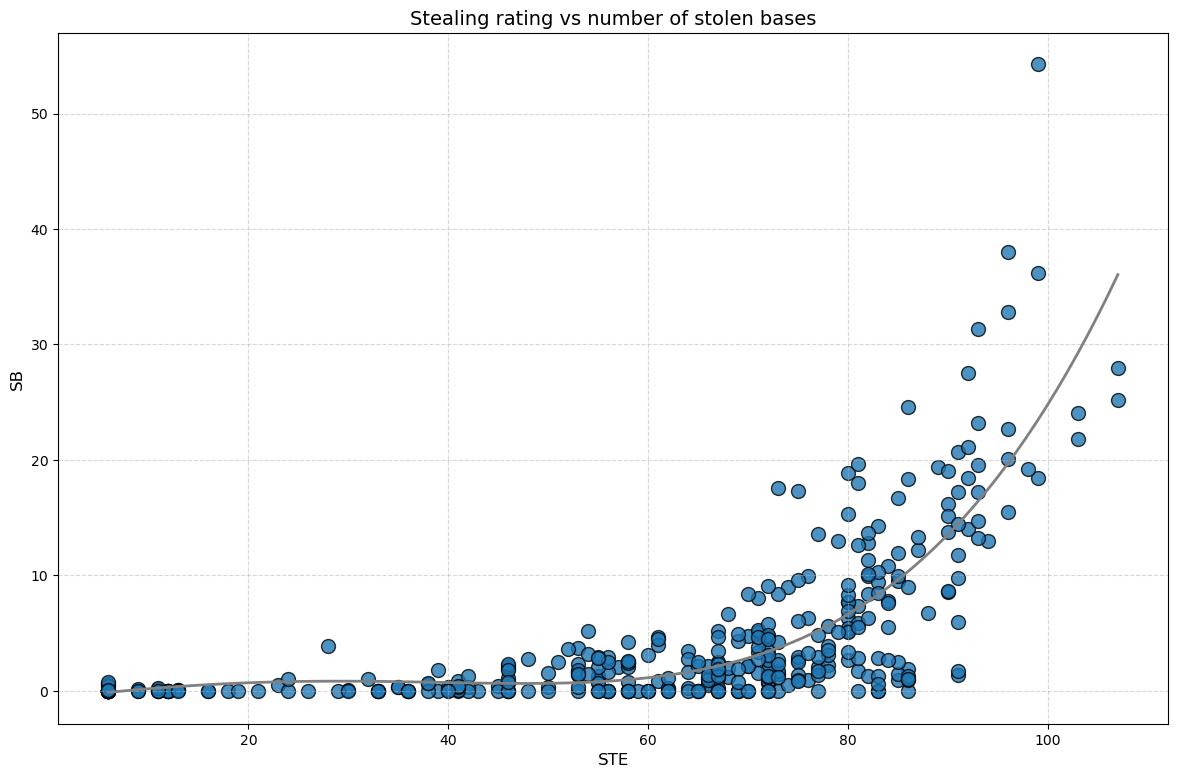

In [52]:
# Remove outliers using IQR method
Qd = df_batters_agg['SB'].astype(float).quantile(0.05)
Qu = df_batters_agg['SB'].astype(float).quantile(0.95)
IQR = Qu - Qd
lower_bound = Qd - 1.5 * IQR # not excluding anything but good to have it for completness
upper_bound = Qu + 1.5 * IQR

# Filter the data to remove outliers
series_sb = np.nan_to_num(df_batters_agg['SB'][(df_batters_agg['PA_WM'] > 200) & (df_batters_agg['SB'] >= lower_bound) & (df_batters_agg['SB'] <= upper_bound)].astype(float), nan=0.0)
series_ste = np.nan_to_num(df_batters_agg['STE'][(df_batters_agg['PA_WM'] > 200) & (df_batters_agg['SB'] >= lower_bound) & (df_batters_agg['SB'] <= upper_bound)].astype(float), nan=0.0)

plt.figure(figsize=(12, 8))
plt.scatter(series_ste, series_sb, s=100,
            marker='o', edgecolors='black', alpha=0.8)

# Calculate polynomial fit
coefficients = np.polyfit(series_ste, series_sb, 4)
polynomial = np.poly1d(coefficients)
x_values = np.linspace(min(series_ste), max(series_ste), 100)
y_values = polynomial(x_values)


# Plot the trendline
plt.plot(x_values, y_values, color='grey', linewidth=2, label='Trendline')

plt.xlabel('STE', fontsize=12)
plt.ylabel('SB', fontsize=12)
plt.title('Stealing rating vs number of stolen bases', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.5)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout(pad=1.5)

plt.show()


The relationship between the number of stolen bases and the stealing rating is superlinear in nature.

#### Ball type and pitcher's Babip

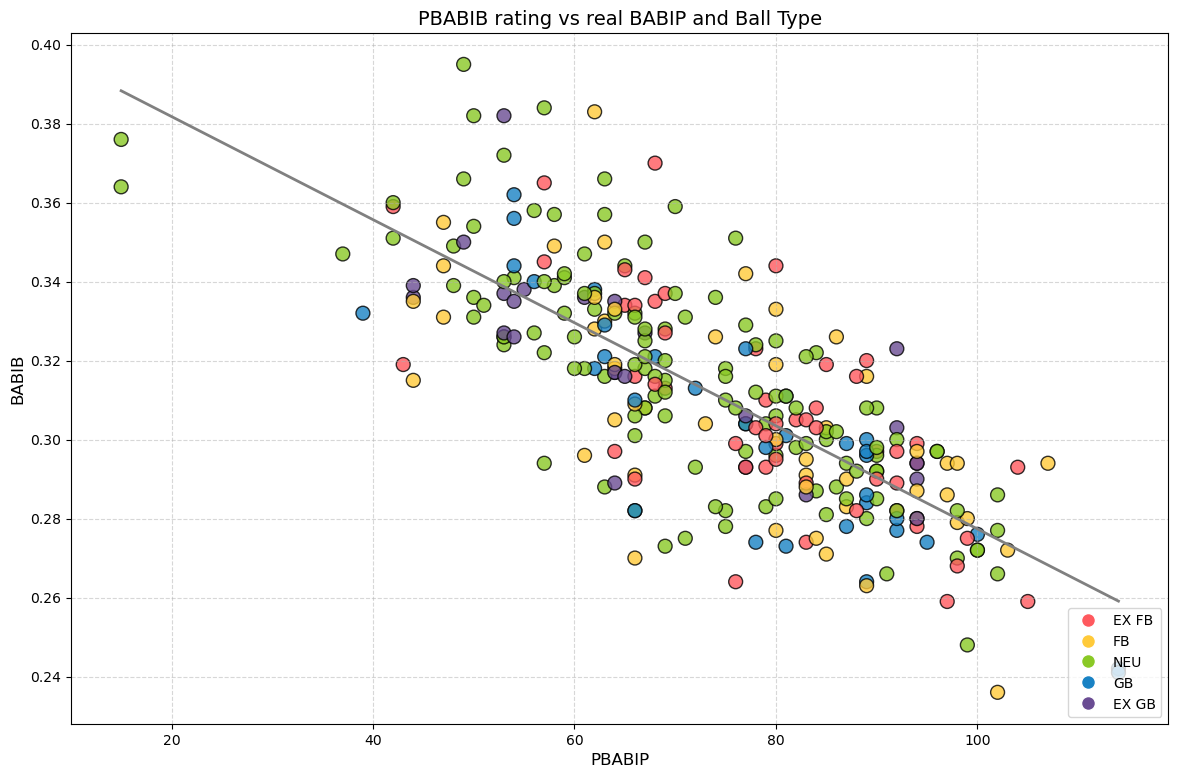

In [53]:
# Does ball type influence pitcher's BABIP?

# Set custom color palette for different 'G/F' categories
colors = {'EX FB': '#FF595E', 'FB': '#FFCA3A', 'NEU': '#8AC926', 'GB': '#1982C4', 'EX GB': '#6A4C93'}
chart_data = df_pitchers_agg[df_pitchers_agg['IP'] > 100]

plt.figure(figsize=(12, 8))

plt.scatter(chart_data['PBABIP'], chart_data['BABIP'], s=100, c=chart_data['G/F'].map(colors),
            marker='o', edgecolors='black', alpha=0.8)

# Fit linear regression
X = sm.add_constant(np.nan_to_num(chart_data['PBABIP'].astype(float), nan=0.0))
model = sm.OLS(np.nan_to_num(chart_data['BABIP'].astype(float), nan=0.0), X)
results = model.fit()
intercept, slope = results.params

x_values = np.linspace(min(np.nan_to_num(chart_data['PBABIP'].astype(float), nan=0.0)), max(np.nan_to_num(chart_data['PBABIP'].astype(float), nan=0.0)), 100)
y_values = intercept + slope * x_values

plt.plot(x_values, y_values, color='grey', linewidth=2, label='Trendline')

plt.xlabel('PBABIP', fontsize=12)
plt.ylabel('BABIB', fontsize=12)
plt.title('PBABIB rating vs real BABIP and Ball Type', fontsize=14)

plt.grid(True, linestyle='--', alpha=0.5)

plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

legend_elements = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=colors['EX FB'], markersize=10, label='EX FB'),
                   plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=colors['FB'], markersize=10, label='FB'),
                   plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=colors['NEU'], markersize=10, label='NEU'),
                   plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=colors['GB'], markersize=10, label='GB'),
                   plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=colors['EX GB'], markersize=10, label='EX GB')]
plt.legend(handles=legend_elements, loc='lower right')

# NOTE: ADD OPACITY BASED ON PITCHED INNINGS

plt.tight_layout(pad=1.5)

# Save the plot as an image (optional)
# plt.savefig('scatter_plot_with_trendline.png', dpi=300)

plt.show()


There appears to be no discernible correlation between ball type and actual BABIP.

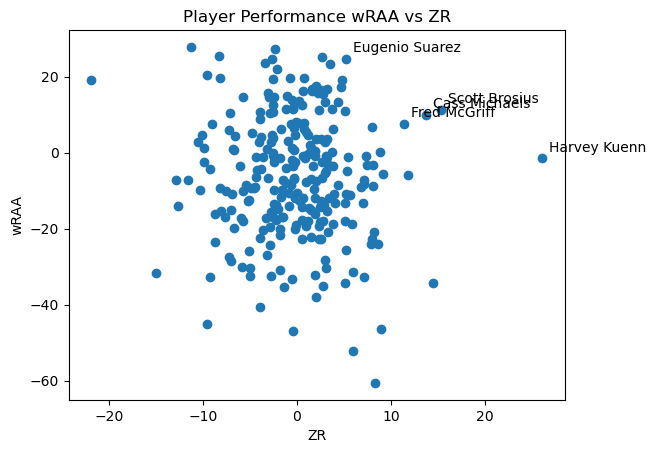

In [54]:
# wRAA vs ZR

# Standardization
def standardize(column):
    mean = np.mean(column)
    std = np.std(column)
    standardized_column = (column - mean) / std
    return standardized_column
# Normalization
def min_max_normalize(column):
    min_val = min(column)
    max_val = max(column)
    normalized_column = [(val - min_val) / (max_val - min_val) for val in column]
    return normalized_column

data = df_batters_agg[(df_batters_agg['PA_WM'] > 500)]

# Separate data into x and y coordinates
x = data['ZR']
y = data['wRAA']
names = data['Name']


plt.scatter(x, y)

# Find the indices of the top 5 records in the right-top quadrant
top_records_indices = sorted(range(len(x)), key=lambda i: (standardize(x).iloc[i] + standardize(y).iloc[i]))[-5:]

# Add names to the top records
for index in top_records_indices:
    plt.annotate(names.iloc[index], (x.iloc[index], y.iloc[index]), xytext=(5, 5), textcoords='offset points')

plt.xlabel('ZR')
plt.ylabel('wRAA')
plt.title('Player Performance wRAA vs ZR')

plt.show()


The goal of this chart was to pinpoint players who excel both in ZR and OPS metrics.

## Modeling

Goal of the modeling part has two main objectives:

1. Predicting wRAA for players with insufficient data collected. This entails utilizing the ratings of the players.

2. Predicting wRAA, considering batting splits, to determine the highest potential of each player under ideal conditions. By ideal conditions is considered the most favorable pitcher handedness (from the batter's perspective).

### Predictors prep

In [55]:
# a predictor for batter splittines
df_batters_agg_model = df_batters_agg.copy()
df_batters_agg_model['Split_Ratio'] = (df_batters_agg_model['CON vL'] + df_batters_agg_model['GAP vL'] + df_batters_agg_model['POW vL'] + df_batters_agg_model['EYE vL']) / (df_batters_agg_model['CON vR'] + df_batters_agg_model['GAP vR'] + df_batters_agg_model['POW vR'] + df_batters_agg_model['EYE vR'])

In [56]:
df_batters_agg_model['Reverse_Split'] = 0
df_batters_agg_model.loc[((df_batters_agg_model['B'] == 'Right') & (df_batters_agg_model['Split_Ratio'] < 0.95)) | ((df_batters_agg_model['B'] == 'Left') & (df_batters_agg_model['Split_Ratio'] > 1.05)),'Reverse_Split'] = 1

In [57]:
# categorical predictors into numerical
df_batters_agg_model = pd.get_dummies(df_batters_agg_model, columns=['BBT','GBT','FBT','B'], drop_first=True)

# Dummy Variable Trap -> two or more dummy variables created by one-hot encoding are highly correlated (multi-collinear) -> drop_first=True

# outliers removal 
# 1) remove of players with not enough data collected based on the plate apperarances
df_batters_agg_model = df_batters_agg_model[df_batters_agg_model['PA_WM'] > 1000]

In [58]:
# size of sample
len(df_batters_agg_model)

186

In [59]:
predictors_batters = [
    'BABIP', 'CON', 'GAP', 'POW', 'EYE', "K's", 'BABIP vL', 'CON vL',
    'GAP vL', 'POW vL', 'EYE vL', 'K vL', 'BABIP vR', 'CON vR', 'GAP vR',
    'POW vR', 'EYE vR', 'K vR', 'BUN', 'BFH', 'BBT_Groundball',
    'BBT_Line Drive', 'BBT_Normal', 'GBT_Normal', 'GBT_Pull',
    'GBT_Spray', 'FBT_Pull', 'FBT_Spray','B_Right','B_Switch','Split_Ratio','Reverse_Split'
]

### Correlation

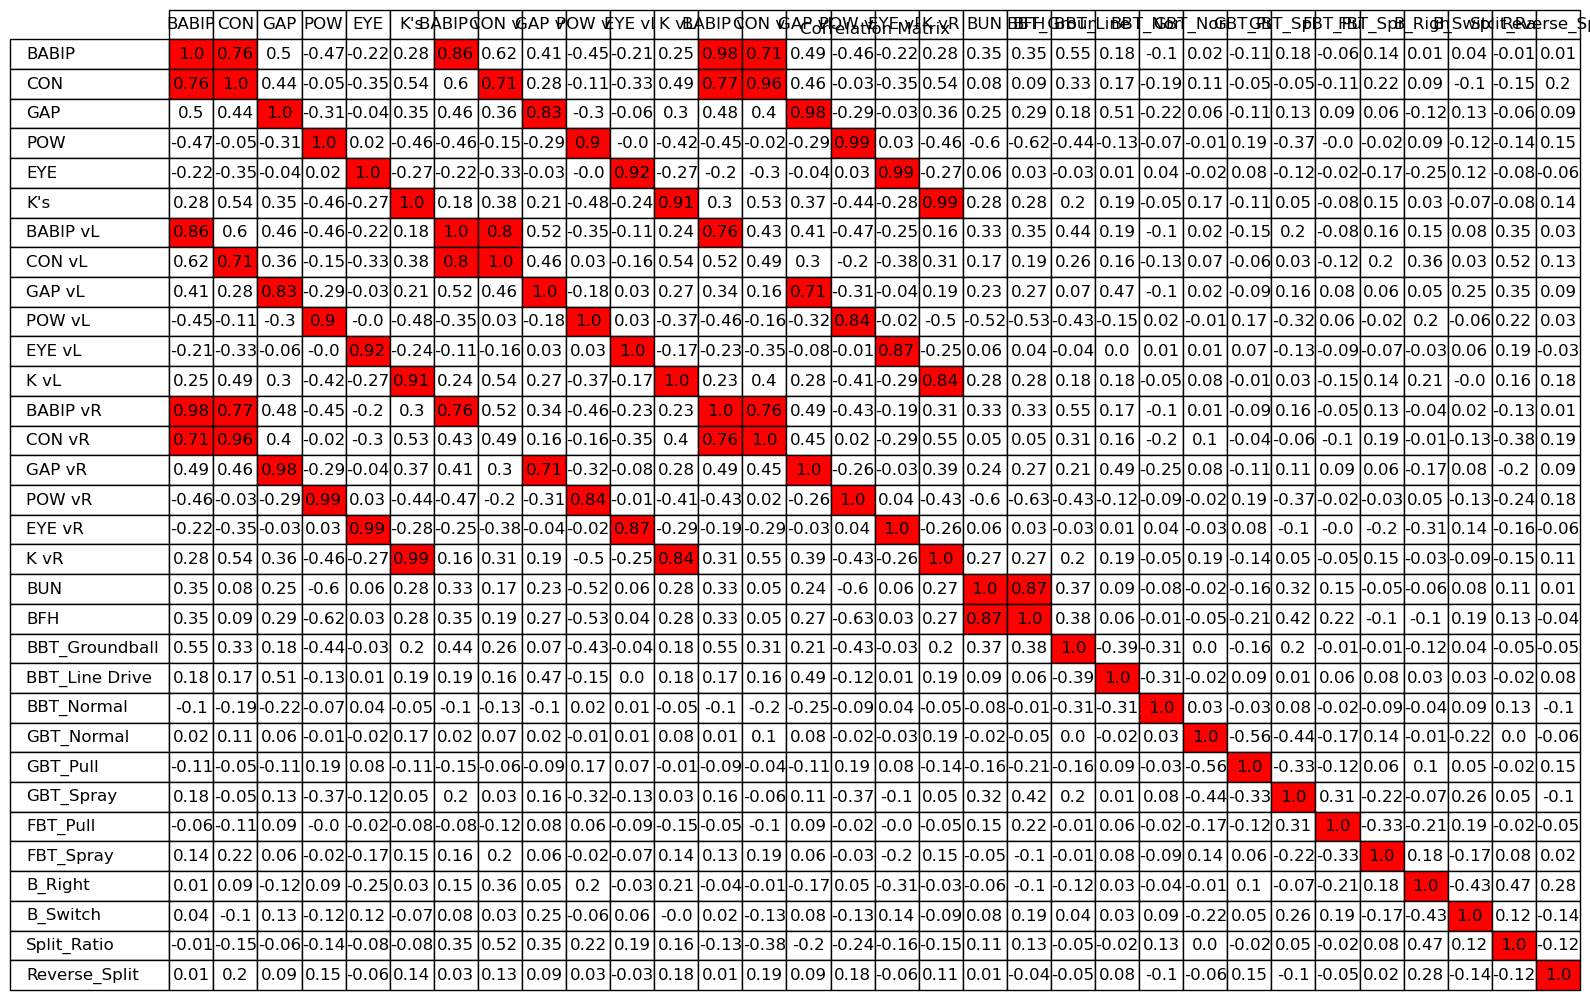

In [60]:
# Correlation matrix
correlation_matrix = df_batters_agg_model[predictors_batters].corr()

fig, ax = plt.subplots(figsize=(16, 10))

table = plt.table(cellText=correlation_matrix.round(2).values,
                  cellColours=np.where(np.abs(correlation_matrix.values) >= 0.7, 'red', 'white'),
                  rowLabels=correlation_matrix.index,
                  colLabels=correlation_matrix.columns,
                  cellLoc='center',
                  loc='center')

table.scale(1, 1.5)
table.auto_set_font_size(False)
table.set_fontsize(12)

ax.axis('off')

plt.title('Correlation Matrix')
plt.tight_layout()
plt.show()

In [61]:
# Function to get correlated pairs from the matrix
def get_correlated_pairs(correlation_matrix, threshold):
    pairs = []
    n = correlation_matrix.shape[0]

    for i in range(n):
        for j in range(i+1, n):
            correlation = correlation_matrix.iloc[i, j]
            if abs(correlation) >= threshold:
                pair = (correlation_matrix.columns[i], correlation_matrix.columns[j], correlation)
                pairs.append(pair)

    return pairs

In [62]:
threshold = 0.8  # Correlation threshold
correlated_pairs = get_correlated_pairs(correlation_matrix, threshold)

for pair in correlated_pairs:
    print(f"{pair[0]} - {pair[1]}: {pair[2]}")

BABIP - BABIP vL: 0.8646752803417528
BABIP - BABIP vR: 0.9831842811924701
CON - CON vR: 0.9613682853838175
GAP - GAP vL: 0.8304577143493076
GAP - GAP vR: 0.9825281510875175
POW - POW vL: 0.9035904623746636
POW - POW vR: 0.9908680521654216
EYE - EYE vL: 0.9204913140227554
EYE - EYE vR: 0.9924515080487912
K's - K vL: 0.9071305215846448
K's - K vR: 0.9901371068835346
POW vL - POW vR: 0.8379142911533384
EYE vL - EYE vR: 0.8661590606099069
K vL - K vR: 0.8400019415366934
BUN - BFH: 0.8650241205860703


In [63]:
# Removal of correlated predictors
for element in ['BABIP vL', 'BABIP vR','CON','CON vL','CON vR','GAP vL','GAP vR','EYE vL','EYE vR','POW vL','POW vR','K vL','K vR','BFH']:
    predictors_batters.remove(element)

<Axes: >

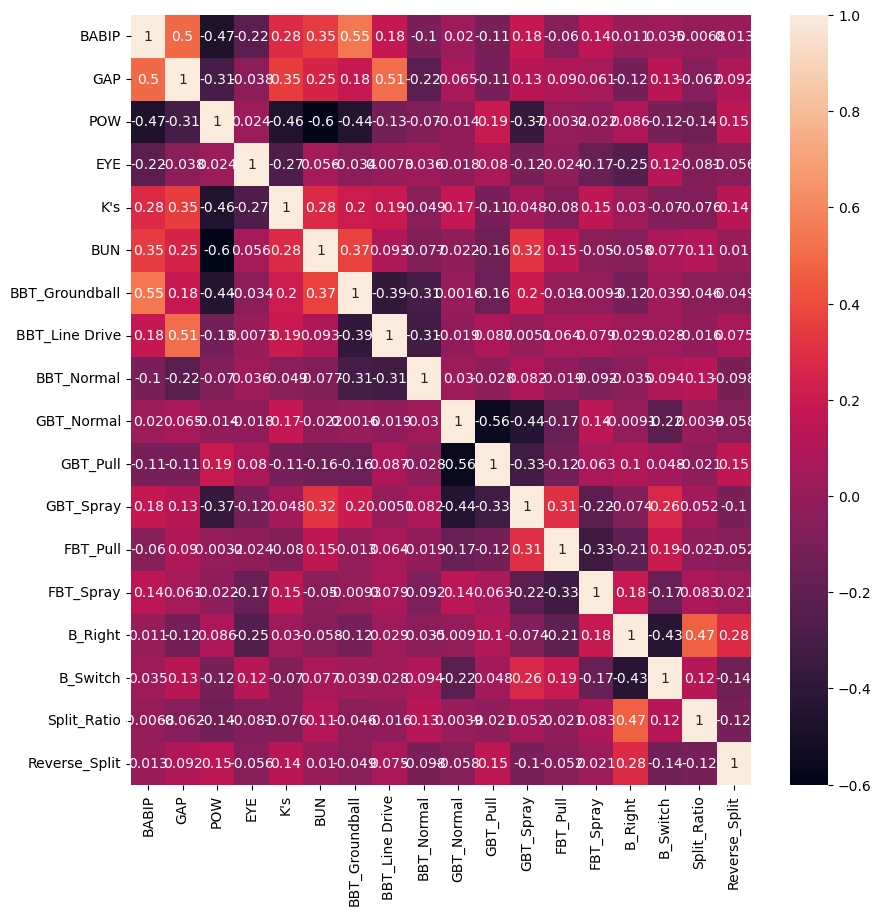

In [64]:
# Heatmap after removing correlated predictors
plt.figure(figsize = (10, 10))
sns.heatmap(df_batters_agg_model[predictors_batters].corr(), annot = True)

In [65]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
  
# the independent variables set
X = df_batters_agg_model[predictors_batters].astype(float).dropna()
  
# VIF dataframe
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
  
# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(X.values, i)
                          for i in range(len(X.columns))]
  
print(vif_data)
# note: VIF under 5 is fine

           feature        VIF
0            BABIP  51.068729
1              GAP  40.017363
2              POW  11.152915
3              EYE  11.461670
4              K's  16.376611
5              BUN   4.841315
6   BBT_Groundball   8.453270
7   BBT_Line Drive   6.562111
8       BBT_Normal   3.488429
9       GBT_Normal   7.731162
10        GBT_Pull   5.373695
11       GBT_Spray   4.655557
12        FBT_Pull   1.689630
13       FBT_Spray   1.810357
14         B_Right   4.329074
15        B_Switch   1.944907
16     Split_Ratio  49.854978
17   Reverse_Split   1.428900


In [66]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [67]:
# predictors and a target variable
X = df_batters_agg_model[predictors_batters].astype('float64')
y = df_batters_agg_model['wRAA'].astype('float64')

# Handle missing values
X = np.nan_to_num(X, nan=0.0)  # Replace NaN values with 0
y = np.nan_to_num(y, nan=0.0)  # Replace NaN values with 0

# # Add a column of ones as the constant term to the predictor matrix
# X = np.append(arr=np.ones((X.shape[0], 1)), values=X, axis=1)

## Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("Size of train sample: " + str(len(X_train)))
print("Size of test sample: " + str(len(X_test)))

Size of train sample: 148
Size of test sample: 38


### Backward OLS elimination

In [68]:
def backward_elimination(pred, dep, pn, significance_level=0.05):
    num_predictors = pred.shape[1]
    for i in range(num_predictors):
        regressor_OLS = sm.OLS(dep, pred).fit()
        max_pvalue = max(regressor_OLS.pvalues).astype(float)
        if max_pvalue > significance_level:
            for j in range(num_predictors - i):
                if regressor_OLS.pvalues[j].astype(float) == max_pvalue:
                    pred = np.delete(pred, j, 1)
                    del pn[j-1] # -1 because there's an extra constant
    regressor_OLS.summary()
    return pred, pn

In [69]:
pred_names = predictors_batters.copy()

# Addition of intercept (a column of ones)
X_trn_ols = sm.add_constant(X_train)
X_tst_ols = sm.add_constant(X_test)

# Perform backward elimination
XPN = backward_elimination(X_trn_ols, y_train, pred_names, 0.1)
X_trn_ols = XPN[0]
pred_names = XPN[1]

# Fit the final model
regressor = sm.OLS(y_train, X_trn_ols).fit()

# Print the summary of the final model
print(regressor.summary())
print("Predictor names:", pred_names, sep="\n")

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.823
Model:                            OLS   Adj. R-squared:                  0.810
Method:                 Least Squares   F-statistic:                     63.70
Date:                Sun, 28 Jan 2024   Prob (F-statistic):           1.50e-46
Time:                        17:18:38   Log-Likelihood:                -488.60
No. Observations:                 148   AIC:                             999.2
Df Residuals:                     137   BIC:                             1032.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -122.1225      6.028    -20.260      0.0

In [70]:
# notes: kurtosis is over 4 -> distribution is too peaked, J-B -> non-normality of residuals

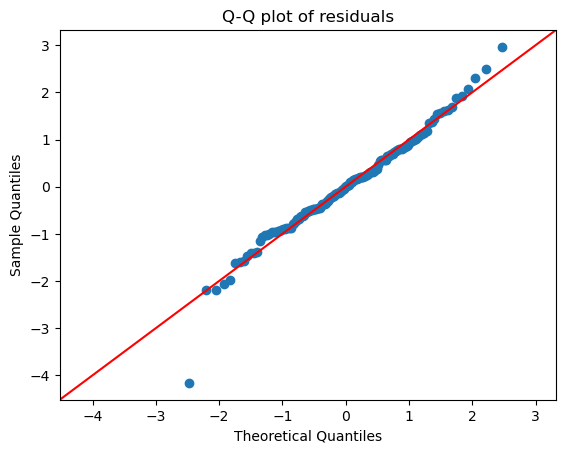

In [71]:
# check for normality of residuals
residuals = regressor.resid

sm.qqplot(residuals, line='45', fit=True)
plt.title("Q-Q plot of residuals")
plt.show()

In [72]:
# Create a dictionary to map index labels to positions
position_dict = {label: position for position, label in enumerate(predictors_batters)}

# Retrieve positions of columns from the dictionary
column_positions = [position_dict[column] + 1 for column in pred_names]
column_positions = np.insert(column_positions, 0, 0)

# Apply results of backward elimination to test sample
X_test_be = X_tst_ols[:, column_positions]

In [73]:
from sklearn.metrics import mean_squared_log_error, r2_score

# Make predictions on the testing data
y_pred = regressor.predict(X_test_be)

# RMSLE = np.sqrt( mean_squared_log_error(y_test, y_pred) )
# print("The rmse score is %.5f" % RMSLE )

train_r2 = r2_score(y_true=y_test, y_pred=y_pred)
print ("The R2 score is {:.2f}%".format(train_r2*100))

The R2 score is 63.33%


In [74]:
# Sample is extremely small -> cross-validation
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression

# Cross-validation
scores = cross_val_score(LinearRegression(), X_trn_ols, y_train, cv=5)

# Print the cross-validation scores
print("Cross-validation scores:", scores)
print("Mean score:", np.mean(scores))


Cross-validation scores: [0.63558424 0.83084342 0.82165317 0.50835437 0.90703085]
Mean score: 0.7406932117896599


### XGBoost

In [75]:
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor

In [76]:
def grid_search_cv(X, y, ts, cvn):
    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=ts, random_state=42)

    rf = RandomForestRegressor()

    # Define hyperparameters grid for tuning
    param_grid = {
        'n_estimators': [25, 50, 100, 150, 200], #5,10, 
        'max_depth': [3,4,5, 6,7], # none, 10 
        'min_samples_split': [ 10, 15, 20],
        'min_samples_leaf': [ 10, 15, 20],
        'bootstrap': [True] # False
        # overfitting: n_estimators up, max_depth down, min_samples_split up, bootstrap true, oob_score true, ccp_alpha?
        
    }

    # Use GridSearchCV to find the best hyperparameters
    grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, 
                               cv=cvn, n_jobs=-1, verbose=2, scoring='r2')

    grid_search.fit(X_train, y_train)

    print("Best Hyperparameters:", grid_search.best_params_)

    best_rf = grid_search.best_estimator_

    # Evaluate
    #full_score = best_rf.score(X, y)
    #print("Full R^2 Score:", full_score)

    train_score = best_rf.score(X_train, y_train)
    print("Train R^2 Score:", train_score)

    test_score = best_rf.score(X_test, y_test)
    print("Test R^2 Score:", test_score)

    return best_rf

In [77]:
# predictors and a target variable
X = df_batters_agg_model[predictors_batters].astype('float64')
y = df_batters_agg_model['wRAA'].astype('float64')

# Handle missing values
#X = np.nan_to_num(X, nan=0.0)  # Replace NaN values with 0
#y = np.nan_to_num(y, nan=0.0)  # Replace NaN values with 0

In [78]:
best_rf = grid_search_cv(X, y, 0.2, 4)

Fitting 4 folds for each of 225 candidates, totalling 900 fits
Best Hyperparameters: {'bootstrap': True, 'max_depth': 5, 'min_samples_leaf': 10, 'min_samples_split': 20, 'n_estimators': 50}
Train R^2 Score: 0.6787234170776341
Test R^2 Score: 0.4640974675113604


In [79]:
# selected predictors
# best_rf = grid_search_cv(X[pred_names], y, 0.4, 3) 

In [80]:
# Cross-validation
scores = cross_val_score(best_rf, X, y, cv=3)

# Print the cross-validation scores
print("Cross-validation scores:", scores)
print("Mean score:", np.mean(scores))


Cross-validation scores: [0.2329783  0.52052771 0.26945801]
Mean score: 0.340988006581203


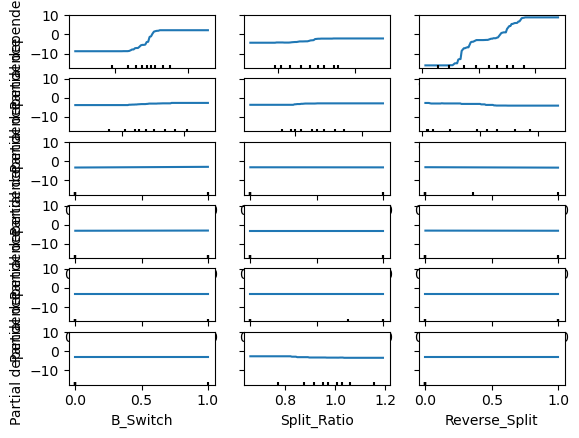

In [81]:
# How does each feature affect the output? 
# Partial Dependence Plots

from sklearn.inspection import PartialDependenceDisplay

display = PartialDependenceDisplay.from_estimator(best_rf, X, list(range(0,X.shape[1])))


In [82]:
# XGBRFRegressor (random forest)
xgb_model = xgb.XGBRFRegressor(objective ='reg:squarederror') # , colsample_bytree=0.2, learning_rate = 0.2, max_depth=5, alpha=5, n_estimators=40

# Fit the model to the training data
xgb_model.fit(X, y)

XGBRFRegressor(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bytree=None,
               early_stopping_rounds=None, enable_categorical=False,
               eval_metric=None, feature_types=None, gamma=None, gpu_id=None,
               grow_policy=None, importance_type=None,
               interaction_constraints=None, max_bin=None,
               max_cat_threshold=None, max_cat_to_onehot=None,
               max_delta_step=None, max_depth=None, max_leaves=None,
               min_child_weight=None, missing=nan, monotone_constraints=None,
               n_estimators=100, n_jobs=None, num_parallel_tree=None,
               objective='reg:squarederror', predictor=None, random_state=None,
               reg_alpha=None, ...)

In [83]:
# Cross-validation
scores = cross_val_score(xgb_model, X, y, cv=5) 

# Print the cross-validation scores
print("\nCross-validation scores:", scores)
print("Mean score:", np.mean(scores))


Cross-validation scores: [0.53382945 0.55576969 0.62364629 0.37448704 0.55829488]
Mean score: 0.5292054720881166


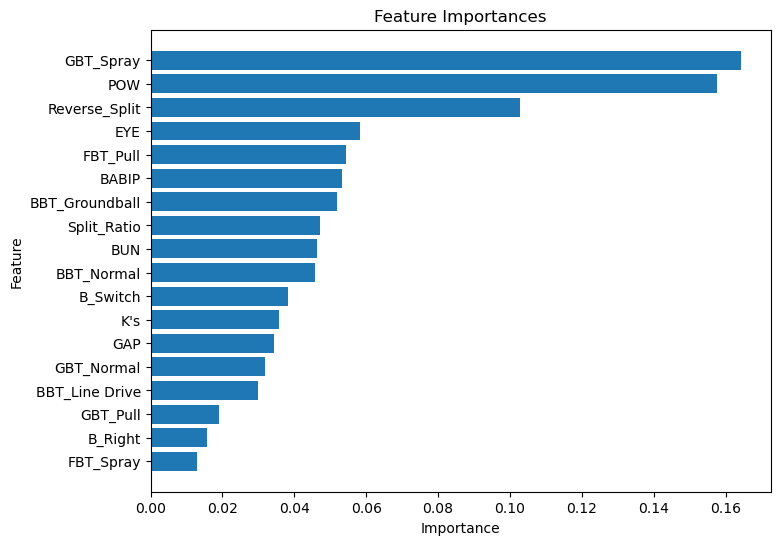

In [84]:
# Get feature importances
importance = xgb_model.feature_importances_

# Create a DataFrame to hold the feature names and importances
feature_importances = pd.DataFrame({'Feature': X.columns, 'Importance': importance})

# Sort the features by importance in descending order
feature_importances = feature_importances.sort_values(by='Importance', ascending=True)

# Plot feature importances
plt.figure(figsize=(8, 6))
plt.barh(feature_importances['Feature'], feature_importances['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances')
plt.show()

In [85]:
feature_importances

,Feature,Importance
13,FBT_Spray,0.012979
14,B_Right,0.015788
10,GBT_Pull,0.019050
7,BBT_Line Drive,0.029979
9,GBT_Normal,0.031901
1,GAP,0.034287
4,K's,0.035717
15,B_Switch,0.038143
8,BBT_Normal,0.045872
5,BUN,0.046297


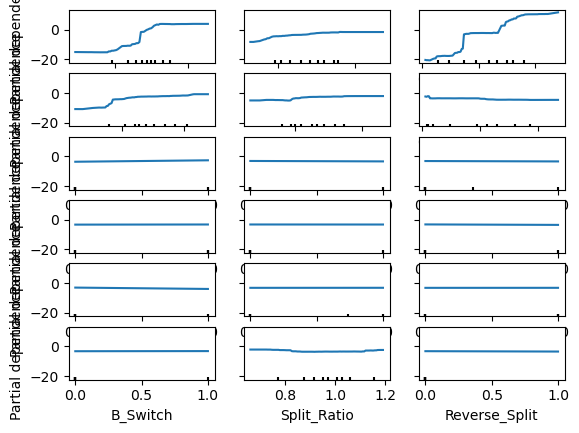

In [86]:
PartialDependenceDisplay.from_estimator(xgb_model, X, list(range(0,X.shape[1])))

### Prediction

In [87]:
# a predictor for batter splittines
df_batters_agg['Split_Ratio'] = (df_batters_agg['CON vL'] + df_batters_agg['GAP vL'] + df_batters_agg['POW vL'] + df_batters_agg['EYE vL']) / (df_batters_agg['CON vR'] + df_batters_agg['GAP vR'] + df_batters_agg['POW vR'] + df_batters_agg['EYE vR'])

In [88]:
df_batters_agg['Reverse_Split'] = 0
df_batters_agg.loc[((df_batters_agg['B'] == 'Right') & (df_batters_agg['Split_Ratio'] < 0.95)) | ((df_batters_agg['B'] == 'Left') & (df_batters_agg['Split_Ratio'] > 1.05)),'Reverse_Split'] = 1

In [89]:
# Predict wRAA
# categorical predictors into numerical
df_batters_agg = pd.get_dummies(df_batters_agg, columns=['BBT','GBT','FBT','B'], drop_first=True)

# a predictor for batter splittines
df_batters_agg['Split_Ratio'] = (df_batters_agg['BABIP vL'] + df_batters_agg['GAP vL'] + df_batters_agg['POW vL'] + df_batters_agg['EYE vL'] + df_batters_agg['K vL']) / (df_batters_agg['BABIP vR'] + df_batters_agg['GAP vR'] + df_batters_agg['POW vR'] + df_batters_agg['EYE vR'] + df_batters_agg['K vR'])

In [90]:
df_batters_agg['wRAA_pred'] = xgb_model.predict(df_batters_agg[predictors_batters])

In [91]:
df_batters_agg['wRAA_pred_R'] = xgb_model.predict(df_batters_agg.rename(columns={'BABIP':'BABIP OR',
'GAP':'GAP OR',
'POW':'POW OR',
'EYE':'EYE OR',
"K's":'K OR',
'BABIP vR':'BABIP',
'GAP vR':'GAP',
'POW vR':'POW',
'EYE vR':'EYE',
"K vR":"K's"})[predictors_batters])


In [92]:
df_batters_agg['wRAA_pred_L'] = xgb_model.predict(df_batters_agg.rename(columns={'BABIP':'BABIP OR',
'GAP':'GAP OR',
'POW':'POW OR',
'EYE':'EYE OR',
"K's":'K OR',
'BABIP vL':'BABIP',
'GAP vL':'GAP',
'POW vL':'POW',
'EYE vL':'EYE',
"K vL":"K's"})[predictors_batters])


In [93]:
df_batters_agg[df_batters_agg['POS'] != 'None'].sort_values('wRAA_pred_L', ascending = False)[['Name','B_Right','CON','GAP','POW','EYE','wRAA_pred','wRAA_pred_L','wRAA_pred_R']].drop_duplicates().head(10)

,Name,B_Right,CON,GAP,POW,EYE,wRAA_pred,wRAA_pred_L,wRAA_pred_R
66,Pat Burrell,1,70,80,72,86,11.993086,18.501806,0.664575
515,Candy Maldonado,1,80,79,63,61,4.491839,18.460653,-0.714307
399,Don Lock,1,67,53,77,87,15.074517,16.058498,14.249745
257,Scott Brosius,1,78,74,72,75,-6.523352,16.011747,-9.580468
2,Billy Butler,1,99,64,80,57,13.139028,15.009748,11.640499
691,Nelson Cruz,1,67,71,84,49,-1.037087,14.322276,-2.657150
141,Mark Bellhorn,0,64,65,77,90,13.177502,14.038682,-4.784335
187,Bob Horner,1,91,53,120,48,14.739644,14.011534,14.625751
664,Jim Lemon,1,64,60,74,63,11.646119,13.685090,6.162467
701,Pete Incaviglia,1,62,46,80,60,11.124040,12.954808,11.121083


In [94]:
df_batters_agg[df_batters_agg['POS'] != 'None'].sort_values('wRAA_pred_R', ascending = False)[['Name','B_Right','CON','GAP','POW','EYE','wRAA_pred','wRAA_pred_L','wRAA_pred_R']].drop_duplicates().head(10)

,Name,B_Right,CON,GAP,POW,EYE,wRAA_pred,wRAA_pred_L,wRAA_pred_R
188,Bobby Estalella,1,89,74,81,108,23.459034,11.017612,23.401869
625,Bobby Abreu,0,87,71,76,113,22.067568,6.249894,23.270498
501,Andre Ethier,0,93,87,79,63,20.876785,-4.894572,20.511234
485,Eugenio Suarez,1,91,41,120,78,17.361446,7.640725,18.790863
19,Earl Williams,1,91,49,103,53,17.516331,-8.164224,16.980970
213,Eric Hinske,0,86,90,75,78,16.241764,-3.434882,16.645500
20,Eddie Murray,0,81,55,76,53,-0.462502,-9.973645,15.600952
123,Jed Lowrie,0,86,90,70,85,12.897929,1.979875,15.564409
638,Chris Duncan,0,73,48,90,65,13.354753,-3.699136,15.209076
657,Ivan Calderon,1,85,77,83,66,13.973258,12.436891,14.686661


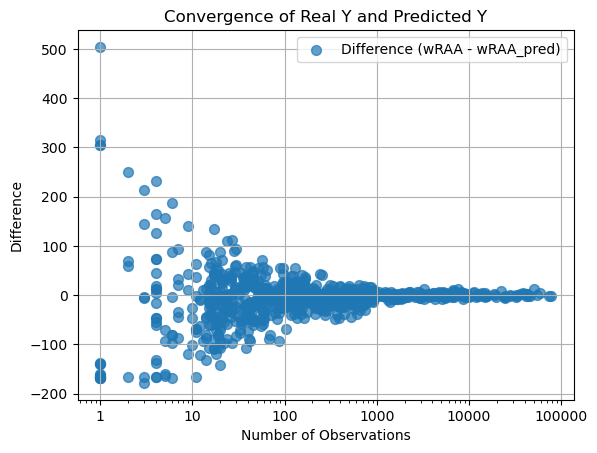

In [95]:
from matplotlib.ticker import ScalarFormatter

def plot_convergence(observations, wRAA, wRAA_pred):
    differences = np.array(wRAA) - np.array(wRAA_pred)

    plt.scatter(observations, differences, s=50, alpha=0.7, label='Difference (wRAA - wRAA_pred)')

    plt.xlabel('Number of Observations')
    plt.ylabel('Difference')
    plt.title('Convergence of Real Y and Predicted Y')
    plt.legend()
    plt.grid(True)
    plt.xscale('log')  # Set logarithmic scale for the x-axis
    #plt.xlim(1, 10000)  # Set x-axis limits
    plt.gca().xaxis.set_major_formatter(ScalarFormatter(useOffset=False))

    plt.show()


plot_convergence( df_batters_agg['PA_WM'], df_batters_agg['wRAA'], df_batters_agg['wRAA_pred'])


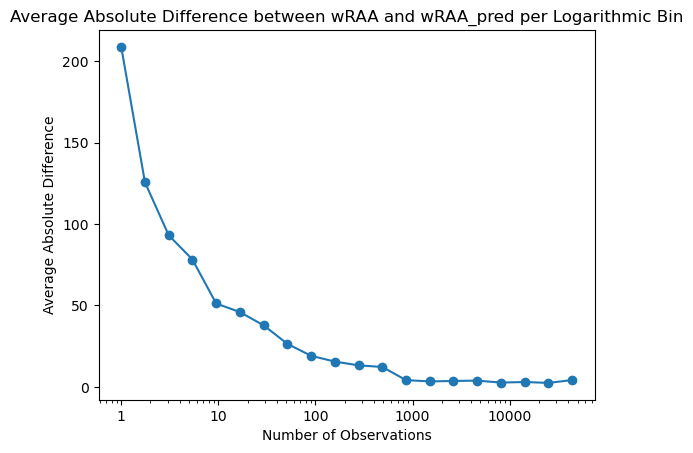

In [96]:
observations = df_batters_agg['PA_WM']
wRAA = df_batters_agg['wRAA']
wRAA_pred = df_batters_agg['wRAA_pred']

# Calculate the absolute differences between ops and ops_pred
differences = np.abs(np.array(wRAA) - np.array(wRAA_pred))

# Calculate the logarithmic bins
log_bins = np.logspace(np.log10(1), np.log10(max(observations)),num=21)

# Calculate the bin indices for each observation
bin_indices = np.digitize(observations, log_bins)

# Calculate the average absolute differences for each bin
bin_averages = [np.mean(differences[bin_indices == i]) for i in range(1, len(log_bins))]


fig, ax = plt.subplots()
ax.plot(log_bins[:-1], bin_averages, 'o-')

ax.set_xscale('log')
ax.set_xlabel('Number of Observations')
ax.set_ylabel('Average Absolute Difference')
ax.set_title('Average Absolute Difference between wRAA and wRAA_pred per Logarithmic Bin')

# Set full number format for x-axis ticks
ax.xaxis.set_major_formatter(ScalarFormatter(useMathText=False))

plt.show()

# Conclusion

This second revised version of this project adopts a more straightforward strategy for increasing winning %, moving away from the complex analysis of the elements behind scoring and preventing runs. Instead, it focuses on available metrics and rediscovery of players when "meta" shifts. The fundamental change lies in transitioning from a team-centric synergy to assessing the individual value of players, aiming to select the best player for each position. This objective is realized by conducting a utilitarian assessment of each player's contribution, encompassing both offense (including baserunning) and defense.

The goal of having a tool to optimize roster was achieved in two steps:
1) new metric to compare players for each position,
2) simulator of players not currently in meta.